This Example teaches the user to use the `main.evolve()` function.  Given a model of decaying or annihilating DM, `main.evolve()` will compute:

    (1) The free electron fraction as a function of redshift, $x_e(z) = n_e(z)/n_{HI}(z)$
    (2) The baryon temperature as a function of redshift, $T_m(z)$
    (3) The high energy photon spectra, and low energy photon/electron spectra as a function of z
    (4) The energy deposition fractions, $f_c(z)$

We will walk the user through an example of DM that either decays or (s-wave) annihilates into photons or $e^+ \, e^-$ pairs. We will calculate the effect of "backreaction" on the energy deposition fractions, $f_c(z)$.

In [1]:
inj_type = 'swave'
inj_particle = 'photon'

# Full Transfer Functions

In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

np.set_printoptions(threshold=np.nan)

In the standard temperature/ionization history calculation,
one solves the TLA assuming no DM energy injection. 

$$ \dot{T}_m = -2 H T_m + \Gamma_C \left(T_{CMB} - T_m \right), $$
$$ \dot{x}_e = - \mathcal{C} \left[ n_H x_e^2 \alpha_B - 4 (1 - x_e) \beta_B e^{-E_{21}/T_{CMB}} \right]. $$

The solution to these coupled ODEs subject to the initial conditions 
$$\left. x_e \right|_{z=3000} = 1$$ $$\left( T_m = T_{CMB} \right)_{z=3000}$$ 
provides the standard $x_e$ and $T_m$ histories, which are loaded below.

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

To include the effect of DM energy injection, one adds to the TLA the following terms

$$ \dot{T}^\chi_m = \frac{2 f_\text{heat}(z)}{3 (1 + f_\text{He} + x_e(z)) n_H(z)} \left(\frac{dE}{dV \, dt} \right)^\text{inj}, $$
$$ \dot{x}^\chi_e = \left[\frac{f_\text{ion}(z)}{\mathcal{R} n_H(z)} + \frac{(1-\mathcal{C}) \; f_\text{exc}(z)}{0.75 \mathcal{R} n_H(z)} \right] \left(\frac{dE}{dV \, dt} \right)^\text{inj}. $$

Apparently one must know $f_{c=\{\text{heat, ion, exc}\}}(z)$ for all z to solve the TLA, which requires a knowledge of the histories of $x_e(z)$ and the DM decay/annihilation products.  Below we will either generate the $f_c$'s by using the standard history values ("without back-reaction"), or by including the effects of DM energy injection ("with back-reaction").

The function _main.evolve()_ will numerically integrate the TLA either with or without back-reaction and generate the $f_c$'s during the integration.  The function requires a number of parameters:

- `in_spec_elec`, `in_spec_phot`:  The spectrum of electrons and photons that come from a single DM decay or annihilation event

- `rate_func_N`, `rate_func_eng`:  $\frac{dN}{dV dt}$ and $\frac{dE}{dV dt}$, particle number and energy injection rates per cubic volume

- `end_rs`: redshift at which the TLA integration ends

- `highengphot_tf_interp`, `lowengphot_tf_interp`, `lowengelec_tf_interp`: interpolated transfer functions for high energy photons and lowenergy photons and electrons

- `xe_init`, `Tm_init`: initial $x_e$ and $T_m$.  If unspecified, will be set to the standard solution.

- `coarsen_factor`:  Described in the next section. Default set to 1.

- `std_soln`: Turn backreaction on/off.  If True, compute TLA without backreaction.  If False, include back-reaction.

We will now calculate each of these parameters.

## Photon Transfer Functions

`highengphot_tf_interp`, `lowengphot_tf_interp`, and `lowengelec_tf_interp`: 

Transfer functions encode how particles (photons and electrons in our case) transfer energy as they evolve within the expanding universe.  For example, a high energy photon will lose energy through redshifting and scattering off of free electrons, producing lower energy photons in the process (what else am I missing???).  

In the following we will assume that particle energies will be binned within log-spaced energy intervals whose log-centers are given by $E^i$ = $E^0 e^{\Delta i}$ for some $\Delta$. Let $E_{in}^i$ be the energy of a single photon injected at redshift $z_{in}$. Due to energy transfer processes that took place over $d(\ln(1+z))$ worth of cosmological time, the photon produces $N^j$ photons at energies $E_{out}^j$.  If we define our transfer function $T^{ij} \equiv T(E_{in}^i, E_{out}^j)$, we have

$$ N_\gamma\left(E^j, (1+z_{in})e^{- d(\ln(1+z))} \right) = T^{ij} N_\gamma\left(E^i, 1+z_{in} \right), $$

where $N_\gamma(E, 1+z)$ represents the number of photons of energy E at redshift 1+z.  The transfer function allows us to evolve photon spectra $d(\ln(1+z))$ amount of time.  This information allows us to evolve DM decay/annihilation products forward in time. We will set $d(\ln(1+z))$ = $0.002$ in our transfer functions, which has been shown to be small enough to provide convergent results.  

Additionally, one may increase the speed of the TLA integration at the expense of precision by "coarsening." This is a process that combines multiples of `coarsen_factor` transfer functions to produce ones that evolve spectra forward by $d(\ln(1+z))$ = $0.002 \; \times$ `coarsen_factor`.  We will avoid coarsening in our example by setting `coarsen_factor` to 1.

We now load the transfer functions. (!!! We should load from some folder in the user's DarkHistory directory that they had to make at some other point)

In [7]:
direc = '/Users/GregoryRidgway/Downloads/complete/'
highengphot_tflist_arr = pickle.load(open(direc+"tfunclist_photspec_60eV_complete.raw", "rb"))

In [ ]:
lowengphot_tflist_arr  = pickle.load(open(direc+"tfunclist_lowengphotspec_60eV_complete.raw", "rb"))

In [ ]:
lowengelec_tflist_arr  = pickle.load(open(direc+"tfunclist_lowengelecspec_60eV_complete.raw", "rb"))

In [ ]:
highengdep_arr = pickle.load(open(direc+"highdeposited_60eV_complete.raw", "rb"))
    #highengdep_arr = pickle.load(open(direc+"highdeposited_60eV_injE_complete_rs_30_xe_2pts.raw", "rb"))
highengdep_arr = np.swapaxes(highengdep_arr, 1, 2)

In [ ]:
CMB_engloss_arr = pickle.load(open(direc+"CMB_engloss_60eV_complete.raw", "rb"))
    #CMB_engloss_arr = pickle.load(open(direc+"CMB_engloss_60eV_injE_complete_rs_30_xe_2pts.raw", "rb"))
CMB_engloss_arr = np.swapaxes(CMB_engloss_arr, 1, 2)

In [8]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])
#xes = 0.5 + 0.5*np.tanh([-5., -4.1])
photeng = highengphot_tflist_arr[0].eng

#Split photeng into high and low energy.
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

for highengphot_tflist in highengphot_tflist_arr:
    for tf in highengphot_tflist:
        # Pad with zeros so that it becomes photeng x photeng.
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )


In [9]:
highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)

In [10]:
pickle.dump(highengphot_tf_interp, open("/Users/gridgway/Desktop/Dark Matter/DH_Data/highengphot_tflist_arr_complete.p", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gridgway/Desktop/Dark Matter/DH_Data/highengphot_tflist_arr_complete.p'

In [5]:
%autoreload
direc = '/Users/GregoryRidgway/Downloads/complete/'
# direc = '/home/gridgway/Downloads/complete/'
(highengphot_tf_interp,
 lowengphot_tf_interp,
 lowengelec_tf_interp,
 highengdep_interp,
 CMB_engloss_interp) = main.load_trans_funcs(direc)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



The above objects are actually `TransferFuncInterpolation` objects.  When given an input $x_e$ and $E_{in}$, these objects output a corresponding transfer function. 

If we are considering annihilation/decay to $e^+ e^-$, then we must also load the ics-related transfer functions

In [76]:
if inj_particle == 'electron':
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()

********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

In [97]:
ics_thomson_ref_tf = pickle.load(open("/home/gridgway/Desktop/DH_Data/ics_thomson_ref_tf.p", "rb"))
ics_rel_ref_tf = pickle.load(open("/home/gridgway/Desktop/DH_Data/ics_rel_ref_tf.p", "rb"))
engloss_ref_tf = pickle.load(open("/home/gridgway/Desktop/DH_Data/engloss_ref_tf.p", "rb"))

## Particle Number/Energy Injection Rates

`rate_func_N`, `rate_func_eng`:

The energy injection rate per volume of decaying DM is given by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)}{\tau_{DM}} $$

and of s-wave annihilating DM by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)^2}{m_{DM}} \sigma_0. $$

To derive the particle number injection rate, just divide by the center of mass energy, 

$$ \left(\frac{dN}{dVdt}\right)_{inj} = \left. \left(\frac{dE}{dVdt}\right)_{inj} \right/ E_{com} $$

which is $m_{DM}$ for decaying DM and $2 m_{DM}$ for annihilating DM.

In [6]:
# mDM = 581399*2
# mDM=2*phys.me + 10**4*2
mDM = 2*10**11
sigmav = 3e-26
tau = 1e25
# mDM = 2*phys.me + 1e3
if inj_type == 'decay':
    Ecom = mDM
elif inj_type == 'swave':
    Ecom = 2*mDM

if inj_particle == 'photon':
    Einj = Ecom/2
elif inj_particle == 'electron':
    Einj = Ecom/2 - phys.me
    
if Einj<0:
    raise TypeError('Choose a mass that corresponds to a positive injection energy.')

Before we can write down the energy/particle number injection rate functions, we must take into account structure formation.

Structure formation has no effect on decay rates, but it serves to enhance annihilation rates due to the decreased interparticle spacing between DM particles.  What we have then is

$$ \left(\frac{dE}{dVdt}\right)_{inj} \longrightarrow \left(\frac{dE}{dVdt}\right)_{inj} \times \left(1 + B(z)\right) $$

where $B(z)$ is the structure formation boost factor.  Below we use the model given by Equation (2.7) in 1408.1109, which gives a boost factor of 

$$ B(z) = \frac{b_h}{(1+z)^\delta} \text{erfc} \left(\frac{1+z}{1+z_h} \right) $$

In [9]:
from scipy.special import erfc as erfc

b_h = 1.6e5
z_h = 19.5
delta = 1.54

def struct_boost_analytic(rs):
    boost_factor = b_h/rs**delta * erfc(rs/(1+z_h))
    return 1 + boost_factor

if inj_type is 'swave':
    struct_boost = struct_boost_analytic
elif inj_type is 'decay':
    def struct_boost(rs):
        return 1

def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)   

Alternatively, we could also use the boost factor given in arxiv:1604.02457, which we include below for convenience.  This structure boost uses input from N_Body simulation and assumes an Einasto DM halo profile including substructure.

In [15]:
struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))

log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))

def struct_boost_einasto(rs):
    if rs < 76:
        return np.exp(log_struct_interp(np.log(rs)))
    else:
        return 1

struct_boost = struct_boost_einasto

## Injected Electron and Photon Spectra

`in_spec_elec`, `in_spec_phot`:

Each DM decay/annihilation event produces a spectrum of electrons or photons.  For a decay event, the spectrum is two photons (one $e^+ e^-$ pair) of energy $m_{DM}/2$ ($m_{DM}/2 - m_e$) and for an annihilation event it is two photons (one $e^+ e^-$ pair) at $m_{DM}$ ($m_{DM} - m_e$).

In [11]:
init_rs = 3000
eleceng = lowengelec_tf_interp.eng
photeng = highengphot_tf_interp.eng

if inj_particle is "electron":
    rest_energy = phys.me
    eng = eleceng
elif inj_particle is "photon":
    rest_energy = 0
    eng = photeng
else:
    raise TypeError('Specify either electron or photon final state')
    
indTmp = spectools.get_indx(eng,Einj)
if eng[indTmp] >= Einj:
    indTmp -= 1

if inj_type == 'decay':
    tmp_spec = spectools.rebin_N_arr(
        np.array([2*Einj/eng[indTmp]]), # Number of particles in each bin
#         np.array([mDM/2 - rest_energy]), # Energy of particles
        np.array([eng[indTmp]]),
        eng # Desired energy abscissa of tmp_spec
    )
else:
    tmp_spec = spectools.rebin_N_arr(np.array([2]), np.array([mDM - rest_energy]), eng)
    
tmp_spec.rs = init_rs
tmp_spec.switch_spec_type()

if inj_particle is "electron":
    elec_spec_init = tmp_spec
    phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs=init_rs, spec_type='N')
else:
    phot_spec_init = tmp_spec
    elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=init_rs, spec_type='N')

__Note__: the rs of `in_spec_elec` and `in_spec_phot` will define rs at which the TLA integration begins.

## main.evolve()

After specifying `end_rs`, we are ready to run main.evolve().

In [43]:
%autoreload
end_rs = 5
std_soln=True
coarsen_factor = 4

tau=1e25
a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=std_soln,
    struct_boost=struct_boost, verbose=False
)

AHHHH YEAHHHH!


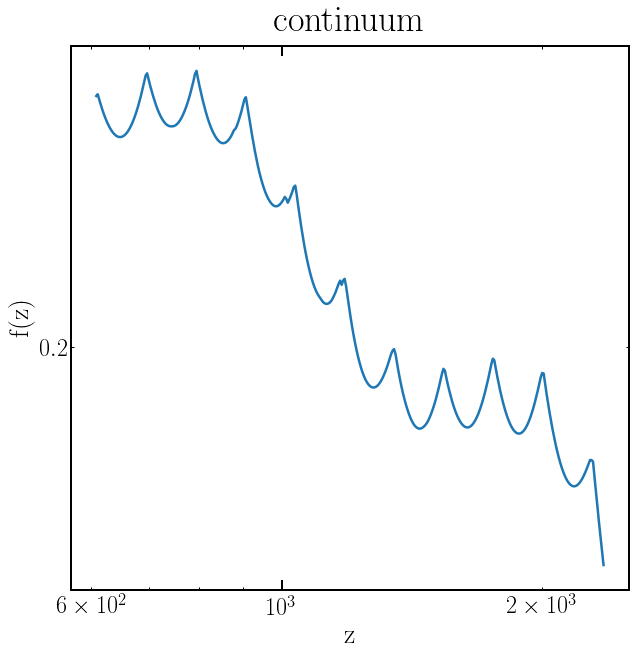

In [41]:
plt.figure()
ax=plt.gca()
ax.loglog()
plt.plot(a1[3].rs[60:-1201], a1[5][60:-1200,4])
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('continuum')
plt.savefig('/Users/GregoryRidgway/Desktop/f_cont_dips.png')

In [123]:
tmp.xes

array([1.0e-04, 1.5e-04, 2.0e-04, 3.0e-04, 5.0e-04, 1.0e-03, 1.5e-03,
       2.0e-03, 3.0e-03, 5.0e-03, 1.0e-02, 1.5e-02, 2.0e-02, 3.0e-02,
       5.0e-02, 1.0e-01, 1.5e-01, 2.0e-01, 3.0e-01, 5.0e-01, 7.0e-01,
       8.0e-01, 9.0e-01, 9.5e-01, 9.9e-01, 1.0e+00])

In [56]:
a1[5][100:,0]

array([ 0.06268469,  0.06262754,  0.06257118,  0.0625133 ,  0.06245188,
        0.0623866 ,  0.06231763,  0.06224526,  0.06216977,  0.06209142,
        0.06201045,  0.06192711,  0.06184159,  0.06175414,  0.06166495,
        0.06157424,  0.06148222,  0.0613891 ,  0.06129511,  0.06120045,
        0.06110536,  0.06101005,  0.06091477,  0.06081974,  0.06072523,
        0.06063149,  0.06053882,  0.06044752,  0.06035796,  0.06027055,
        0.0601858 ,  0.06010433,  0.06002695,  0.05995469,  0.05987913,
        0.05980555,  0.05973059,  0.05965323,  0.05957328,  0.05949066,
        0.05940561,  0.05931838,  0.05922923,  0.05913844,  0.05904622,
        0.05895281,  0.05885844,  0.05876331,  0.05866764,  0.05857166,
        0.05847556,  0.05837949,  0.05828367,  0.05818841,  0.05809395,
        0.05800055,  0.05790847,  0.05781803,  0.05772956,  0.05764344,
        0.05756008,  0.05748002,  0.05740877,  0.05733735,  0.05726939,
        0.05720525,  0.05714369,  0.05708993,  0.05703832,  0.05

In [71]:
tmp = [f_heating(rs,1) for rs in a1[3].rs]

In [55]:
tmp[100:]

[0.063535595603707834,
 0.063528730853787019,
 0.063521866845573149,
 0.063515003578986054,
 0.063508141053945616,
 0.063501279270371747,
 0.063494418228184274,
 0.063487557927303165,
 0.063480698367648233,
 0.06347383954913946,
 0.06345579012506361,
 0.063413067764502812,
 0.063370374167276131,
 0.063327709314018307,
 0.063285073185377128,
 0.063242465762013311,
 0.063199887024600873,
 0.063157336953826484,
 0.063114815530390098,
 0.063072322735004516,
 0.063029858548395531,
 0.062987422951301983,
 0.06294501592447567,
 0.062902637448681284,
 0.062860287504696494,
 0.062817966073311943,
 0.062775673135331223,
 0.062733408671570762,
 0.062691172662859937,
 0.062648965090041128,
 0.062606785933969442,
 0.062564635175513084,
 0.062506587842587127,
 0.062422000773161498,
 0.062337528171227355,
 0.062253169881881551,
 0.062168925750430523,
 0.062084795622390034,
 0.062000779343484927,
 0.061916876759648805,
 0.061833087717023789,
 0.061749412061960121,
 0.061665849641016061,
 0.06158240030

[80, 2000.0, 0, 0.2]

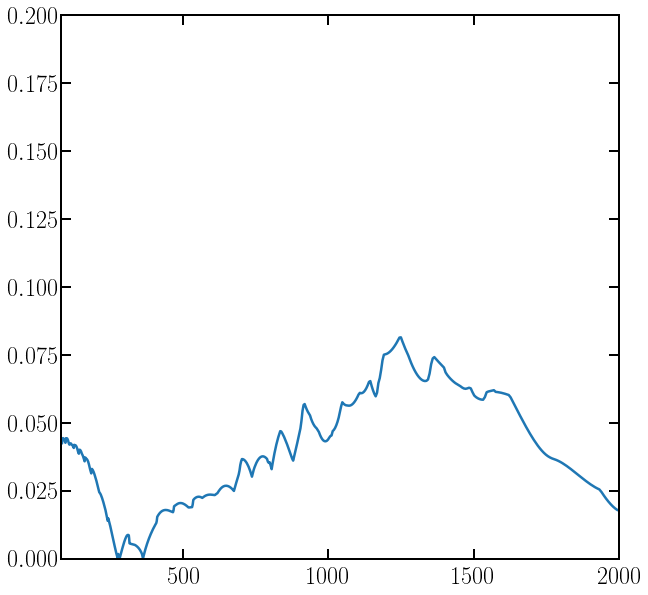

In [72]:
plt.figure()
ax=plt.gca()

plt.plot(a1[3].rs[100:-11], np.abs((a1[5][100:-10,3]-tmp[100:-11])/tmp[100:-11]))
plt.axis([80,2e3,0,.2])

In [134]:
%autoreload
# from darkhistory.low_energy.lowE_electrons import make_interpolator
from darkhistory.low_energy.lowE_electrons import compute_fs
# tmp = make_interpolator()

tmp2 = np.zeros_like(a1[3].rs)
for i,rs in enumerate(a1[3].rs):
    tmp2[i]=compute_fs(a1[4][i], xe_std(rs), phys.inj_rate('decay',mDM=mDM,tau=tau,rs=rs), .001/phys.hubble(rs))[0]

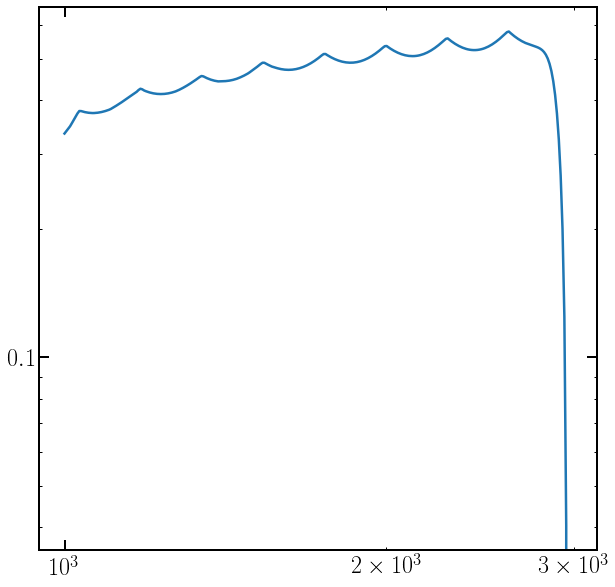

In [96]:
plt.figure()
ax = plt.gca()
ax.loglog()
# plt.plot(a1[3].rs, a1[3].toteng(bound_type='eng', bound_arr=np.array([1e-12,10.2]))[0]/2e-7)
plt.plot(a1[3].rs[1:], a1[5][:,4])
# plt.plot(a1[3].rs[1:], tmp2[1:])

# plt.vlines(redshiftgrid[-9:],10**-2,10**0)
# plt.vlines(redshiftgrid[-9:],10**-15,10**-8)

plt.show()

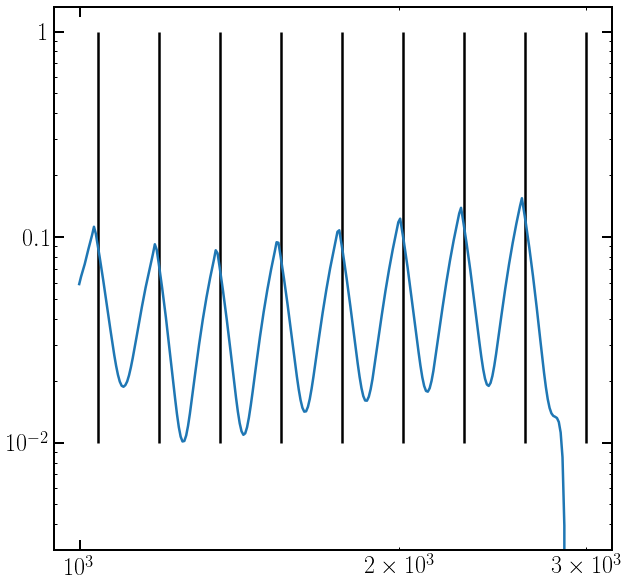

In [588]:
rs_list = [3000*np.exp(-0.001*4*(i+1)) for i in np.arange(6400/4-1)]

plt.figure()
ax = plt.gca()
ax.loglog()
# plt.plot(a1[3].rs, a1[3].toteng(bound_type='eng', bound_arr=np.array([1e-12,10.2]))[0])
plt.plot(a1[3].rs[1:], a1[5][:,4])

plt.vlines(redshiftgrid[-9:],10**-2,10**0)

plt.show()



In [49]:
direc = '/home/gridgway/Dropbox (MIT)/'
direc = '/Users/GregoryRidgway/Downloads/'
fz_elec_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}


#------------------------------------------------------#
fz_phot_swave = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_photon_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_phot_swave[0:70, 1]
log10eng = fz_phot_swave[0:2800:70, 0] 

log10f_phot_swave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_swave[11200:14000,2], (40,70))) 
}

In [52]:
f_interp = log10f_phot_swave

E_tmp=mDM
def f_H_ion(rs, xe):
    interp_func = interp2d(log10eng, log10rs, f_interp['H_ion'])
    return 10**interp_func(np.log10(E_tmp), np.log10(rs))[0]

def f_He_ion(rs, xe):
    interp_func = interp2d(log10eng, log10rs, f_interp['He_ion'])
    return 10**interp_func(np.log10(E_tmp), np.log10(rs))[0]

def f_H_exc(rs, xe):
    interp_func = interp2d(log10eng, log10rs, f_interp['H_exc'])
    return 10**interp_func(np.log10(E_tmp), np.log10(rs))[0]

def f_heating(rs, xe):
    interp_func = interp2d(log10eng, log10rs, f_interp['heating'])
    return 10**interp_func(np.log10(E_tmp), np.log10(rs))[0]

def f_cont(rs, xe):
    interp_func = interp2d(log10eng, log10rs, f_interp['cont'])
    return 10**interp_func(np.log10(E_tmp), np.log10(rs))[0]

[5, 3000.0, 0.0001, 1]

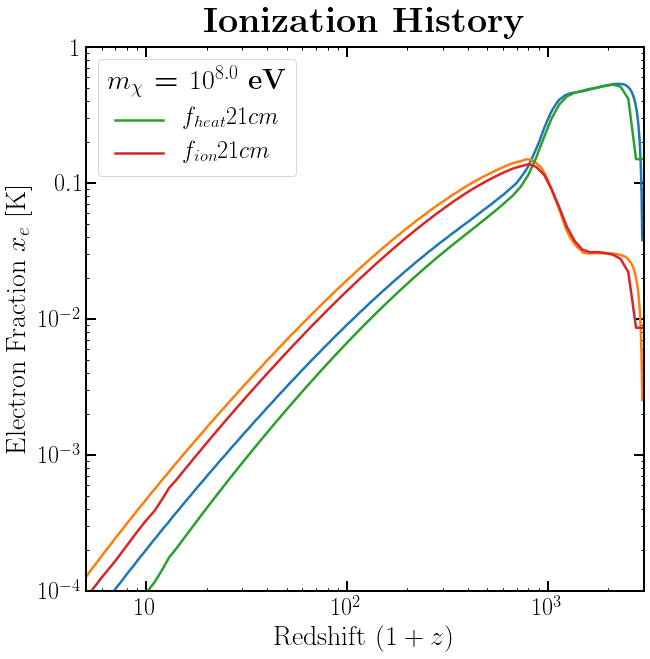

In [670]:
mDM=10**8
soln = np.loadtxt(open("/home/gridgway/Desktop/DarkHistory/darkhistory/history/recfast_standard.txt", "rb"))
tmp = np.array([f_heating(rs,xe) for rs,xe in zip(soln[:,0], soln[:,1])])
tmp2 = np.array([f_H_ion(rs,xe) for rs,xe in zip(soln[:,0], soln[:,1])])

plt.figure()
plt_0, = plt.plot(a1[3].rs[1:], a1[5][:,3], label='$f_{heat}$')
plt_1, = plt.plot(a1[3].rs[1:], a1[5][:,0], label='$f_{ion}$')
plt_2, = plt.plot(soln[:,0], tmp, label='$f_{heat} 21cm$')
plt_3, = plt.plot(soln[:,0], tmp2, label='$f_{ion} 21cm$')

# plt_2, = plt.plot(a2[3].rs[1:], a2[5][:,3], label='$f_{ion}$')
# plt_3, = plt.plot(a2[3].rs[1:], a2[5][:,0], label='$f_{heat}$')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_2, plt_3],#, plt_2, plt_3],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 3e3, 1e-4, 1])
# plt.savefig('/home/gridgway/Desktop/shifted_fs.png')

[5, 2000.0, 0.0001, 1]

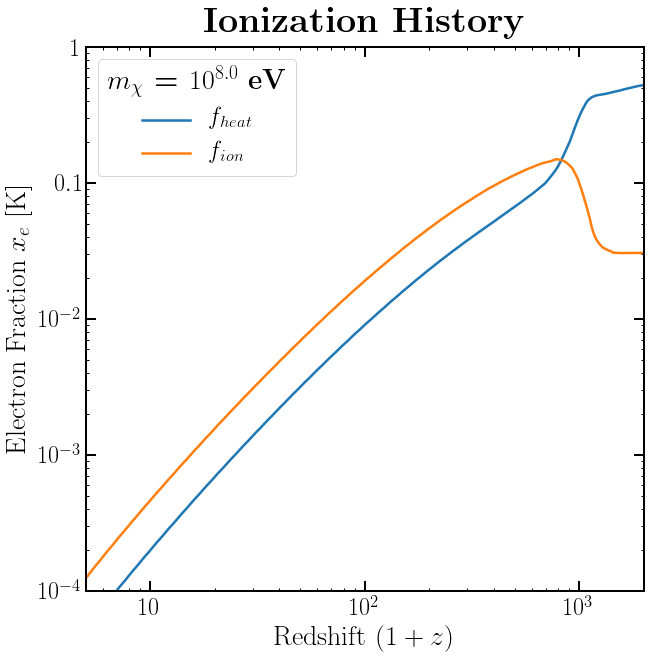

In [399]:
plt.figure()
plt_0, = plt.plot(a1[3].rs[1:], a1[5][:,3], label='$f_{heat}$')
plt_1, = plt.plot(a1[3].rs[1:], a1[5][:,0], label='$f_{ion}$')

# plt_2, = plt.plot(a2[3].rs[1:], a2[5][:,3], label='$f_{ion}$')
# plt_3, = plt.plot(a2[3].rs[1:], a2[5][:,0], label='$f_{heat}$')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_0, plt_1],#, plt_2, plt_3],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 1])
# plt.savefig('/home/gridgway/Desktop/shifted_fs.png')

In [320]:
hdul = fits.open(
    '/home/gridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/'+
#     '/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'+
#     'tf_z_2.915E+01_nstep_3_logE_5.764E+00_xe_2.746E-04.fits'
#     'tf_z_2.915E+01_nstep_3_logE_5.657E+00_xe_2.746E-04.fits'
    'tf_z_3.000E+03_nstep_6398_logE_5.778E+00_xe_0.000E+00.fits'
)


In [321]:
data = hdul[1].data

In [322]:
data.columns.info()

name:
    ['DEPOSITEDENERGY', 'DEP_PROMPT', 'DEP_HIGHENERGY', 'DEP_CASCADES', 'DEP_PHOTOION', 'DEP_COMPTON', 'DEP_LOW', 'DEP_LOW60', 'LOWERBOUND', 'REDSHIFTLOSS', 'PHOTONSPECTRUM', 'COMPTON_ELEC_SPEC', 'HIONFRACTION', 'HEIONFRACTION', 'ENERGY', 'ELECENG', 'REDSHIFT', 'ENERGYCONSERVATION', 'H0', 'OMEGA_M', 'OMEGA_B', 'OMEGA_RAD', 'OMEGA_LAM', 'T_CMB0', 'YHE', 'HUBBLERATE', 'MWIMP', 'CHANNEL', 'SIGMAV', 'ANNRATE', 'IONHIST_VERSION', 'HIGHDEPOSITED', 'HIGHDEP_PROMPT', 'HIGHDEP_HIGHENERGY', 'HIGHDEP_CASCADES', 'HIGHDEP_PHOTOION', 'HIGHDEP_COMPTON', 'HIGHDEP_LOW', 'HIGHDEP_LOW60', 'DEPOSITIONPARTITIONVALS', 'LOWENGELEC', 'LOWENGPHOT', 'LOWENGPHOT_DEPOSITED', 'LOWENGPHOT_CONT', 'CMBLOSSTABLE', 'HIGHDEPOSITED_GRID', 'HIGHDEP_PROMPT_GRID', 'HIGHDEP_HIGHENERGY_GRID', 'HIGHDEP_CASCADES_GRID', 'HIGHDEP_PHOTOION_GRID', 'HIGHDEP_COMPTON_GRID', 'HIGHDEP_LOW_GRID', 'HIGHDEP_LOW60_GRID', 'LOWENGPHOT_ELEMENTGRID', 'LOWENGPHOT_ELEMENTGRID_DEPOSITED']
format:
    ['6398D', '6398D', '6398D', '6398D', '639

## highengphot checks

In [77]:
rs_tmp = data.field('redshift')[0,0]
xe_tmp = data.field('hionfraction')[0,0]
E_tmp = data.field('mwimp')[0]

In [195]:
idl_highengphot_spec = Spectrum(data.field('energy')[0], data.field('photonspectrum')[0][2], rs=rs_tmp)
idl_lowengphot_spec = Spectrum(data.field('energy')[0], data.field('lowengphot')[0][2], rs=rs_tmp)
idl_lowengelec_spec = Spectrum(data.field('eleceng')[0], data.field('lowengelec')[0][2], rs=rs_tmp)

spec = idl_highengphot_spec/norm_fac/(2*extra_fac)

# tmpSpec2 = spec*rate_func_N(rs_tmp)/phys.nB/rs_tmp**3*.002/phys.hubble(rs_tmp)

#!!! Why are there features to the right in the IDL (high energy) 'photonspectrum'

In [79]:
def getInd(eng, E):
    ind = spectools.get_indx(eng, E)
    if eng[ind] > E:
        ind -= 1
    return ind

In [1087]:
indTmp2 = getInd(photeng, E_tmp2)

indTmp = indTmp2

In [189]:
indTmp = getInd(photeng, E_tmp)

In [1172]:
ind4 = getInd(injE, E_tmp2)

indTmp2 = getInd(photeng, injE[ind4+1])
indTmp1 = getInd(photeng, injE[ind4])

terp2 = interp1d(np.arange(indTmp2+1)*(np.log(photeng[indTmp]) - np.log(photeng[0]))/indTmp2 + np.log(photeng[0]), 
                 b[indTmp2].dNdE[:indTmp2+1])

terp1 = interp1d(np.arange(indTmp1+1)*(np.log(photeng[indTmp]) - np.log(photeng[0]))/indTmp1 + np.log(photeng[0]),
                 b[indTmp1].dNdE[:indTmp1+1])

tmp = np.pad(terp1(np.log(photeng[:indTmp+1])) + terp2(np.log(photeng[:indTmp+1])), 
                                                       (0,len(photeng) - indTmp-1), 'constant')

spec = Spectrum(photeng, tmp)
spec.switch_spec_type()

# tmp_spec = Spectrum(photeng, (b[indTmp2].dNdE + b[indTmp1].dNdE)/2)

# tmp_spec *= E_tmp2/tmp_spec.toteng()
spec.toteng()

1254514.8879697348

In [960]:
###!!! Why don't we have delta function injections?
tmp = [(b[i].toteng()+c[i].toteng() + d[i].toteng())/photeng[i] for i in np.arange(len(photeng))]

utils.compare_arr([photeng,tmp])

[[1.03931104e-04 1.00000000e+00]
 [1.12262993e-04 1.00000000e+00]
 [1.21262829e-04 1.00000000e+00]
 [1.30984159e-04 1.00000000e+00]
 [1.41484823e-04 1.00000000e+00]
 [1.52827298e-04 1.00000000e+00]
 [1.65079070e-04 1.00000000e+00]
 [1.78313035e-04 1.00000000e+00]
 [1.92607933e-04 1.00000000e+00]
 [2.08048817e-04 1.00000000e+00]
 [2.24727556e-04 1.00000000e+00]
 [2.42743387e-04 1.00000000e+00]
 [2.62203501e-04 1.00000000e+00]
 [2.83223683e-04 1.00000000e+00]
 [3.05928998e-04 1.00000000e+00]
 [3.30454541e-04 1.00000000e+00]
 [3.56946233e-04 1.00000000e+00]
 [3.85561696e-04 1.00000000e+00]
 [4.16471187e-04 1.00000000e+00]
 [4.49858613e-04 1.00000000e+00]
 [4.85922622e-04 1.00000000e+00]
 [5.24877791e-04 1.00000000e+00]
 [5.66955896e-04 1.00000000e+00]
 [6.12407295e-04 1.00000000e+00]
 [6.61502415e-04 1.00000000e+00]
 [7.14533365e-04 1.00000000e+00]
 [7.71815671e-04 1.00000000e+00]
 [8.33690151e-04 1.00000000e+00]
 [9.00524950e-04 1.00000000e+00]
 [9.72717723e-04 1.00000000e+00]
 [1.050698

0

In [901]:
b[indTmp].toteng()/(tmpSpec.toteng()/norm_fac/(2*extra_fac))

0.6586843219106007

In [89]:
ind3 = spectools.get_indx(photeng,phys.TCMB(rs_tmp))

In [177]:
ind4 = spectools.get_indx(b.in_eng,phys.me*2)

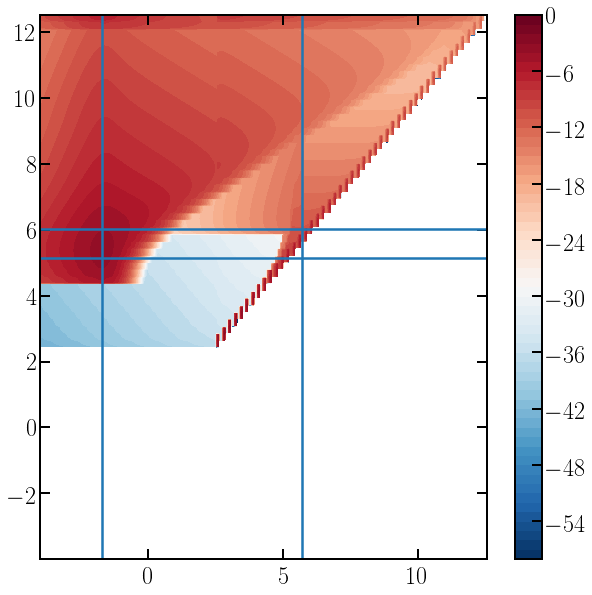

In [190]:
plt.figure()
ax = plt.gca()

rs_tmp3 = rs_tmp*1.0000000001

b = highengphot_tf_interp.get_tf(rs=rs_tmp3,xe=xe_tmp)

a = b._grid_vals
a = np.array([c/in_eng for c, in_eng in zip(a, b.in_eng)])
a[a<=0] = 1e-200
levels = np.arange(59)-58

plt.contourf(np.log10(b.eng), np.log10(b.in_eng), np.log10(a), levels=levels, cmap="RdBu_r")
ax.axvline(x=np.log10(2.82 * phys.TCMB(rs_tmp3)))
ax.axvline(x=np.log10(phys.me))
ax.axhline(y=np.log10(b.in_eng[ind4+1]))
ax.axhline(y=np.log10(.28*phys.me))
plt.colorbar()

plt.show()

In [193]:
E_tmp

453665.59999999998

425290.025703


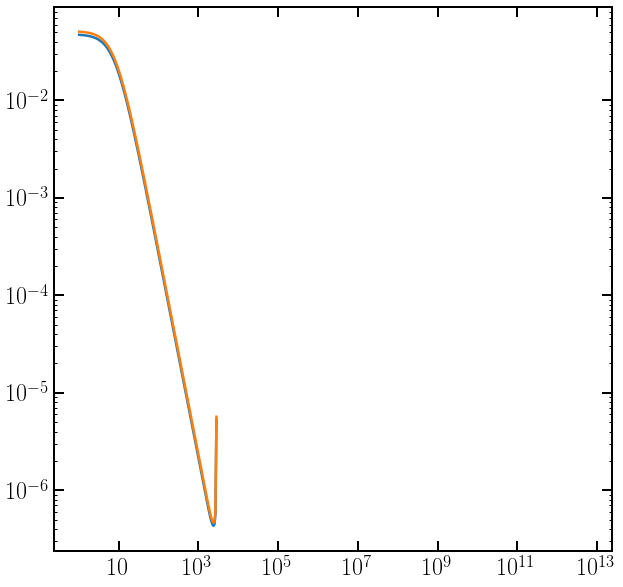

In [212]:
plt.figure()
ax = plt.gca()
tau=1e25

rs_tmp=29.146

ax.loglog()

def rate_func_N2(rs):
    return phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)/E_tmp

b = highengphot_tf_interp.get_tf(rs=rs_tmp,xe=xe_tmp)
c = lowengphot_tf_interp.get_tf(rs=rs_tmp,xe=xe_tmp)
d = lowengelec_tf_interp.get_tf(rs=rs_tmp,xe=xe_tmp)
if b.spec_type != 'dNdE':
    b.switch_spec_type()
    c.switch_spec_type()
    d.switch_spec_type()
    
print(b.in_eng[indTmp])
# if a2[2].spec_type != 'dNdE':
#     a2[2].switch_spec_type()

norm_fac = rate_func_N2(rs_tmp) * 0.002 / phys.hubble(rs_tmp) / (phys.nB * rs_tmp**3)
extra_fac = .5+0*E_tmp/photeng[indTmp]
idl_spec = idl_lowengelec_spec/norm_fac/(2*extra_fac)

# fac = idl_highengphot_spec.dNdE[ind3]/norm_fac/(2*extra_fac)/spec.dNdE[ind3]
d.plot(ax=ax, ind=indTmp, indtype='ind')
plt.plot(idl_spec.eng, idl_spec.dNdE)

#!!! lowengelec looks messed up
# plt.savefig('/home/gridgway/Desktop/f_contour_debug/MootPoint.png')

In [937]:
b[indTmp].toteng(bound_type='eng', bound_arr=[1e-12,1e4])/tmpSpec.toteng(
    bound_type='eng', bound_arr=[1e-12,1e4])*norm_fac*(2*extra_fac)

array([0.99650418])

In [204]:
print("No interpolation residual: ", np.sqrt(np.sum(
    (idl_spec.dNdE[:494] - c[indTmp].dNdE)**2)
       )/np.sqrt(np.sum(c[indTmp].dNdE**2))
     )


No interpolation residual:  0.076950115644


In [857]:
print("rs_interpolation residual: ", np.sqrt(np.sum(
    (tmpSpec.dNdE[:494]/norm_fac/(2*extra_fac) - b[indTmp].dNdE)**2)
       )/np.sqrt(np.sum(b[indTmp].dNdE**2))
     )

rs_interpolation residual:  0.011978232787259672


In [810]:
print("xe interpolation residual: ", np.sqrt(np.sum(
    (tmpSpec.dNdE[:494]/norm_fac/(2*extra_fac) - b[indTmp].dNdE)**2)
       )/np.sqrt(np.sum(b[indTmp].dNdE**2))
     )

xe interpolation residual:  0.011538938487274938


In [967]:
print("E_inj interpolation residual: ", np.sqrt(np.sum(
    (tmpSpec.dNdE[:494]/norm_fac/(2*extra_fac) - b[indTmp].dNdE)**2)
       )/np.sqrt(np.sum(b[indTmp].dNdE**2))
     )

E_inj interpolation residual:  0.035730362870115405


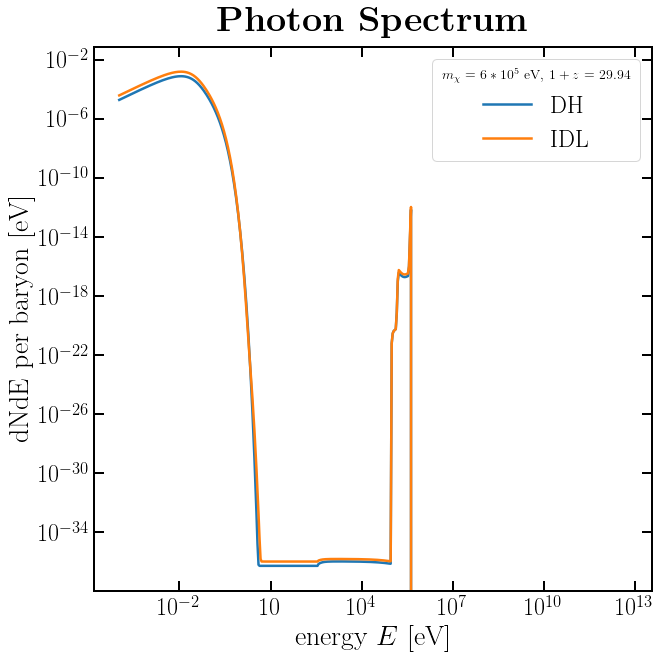

In [698]:
%autoreload
ind=1
plt.figure()
ax=plt.gca()
ax.loglog()

#!!! slight difference between a1[2] and the highengphot I generated
a2[2].plot(ax=ax, ind=ind, indtype='ind', label='stuff2', color='C0')
# a1[3].plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff2', color='C1')
# a1[3].plot(ax=ax, ind=rs_list[ind+1], indtype='rs', label='stuff2', color='C1')
# phot_spectra.plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff', color='C0')
# plt.plot(tmpSpec2.eng, tmpSpec2.N)
# plt.plot(tmpSpec3.eng, tmpSpec3.dNdE, color='C2')
# plt.plot(tmpSpec2.eng, tmpSpec2.dNdE, color='C2')
plt.plot(tmpSpec.eng, tmpSpec.dNdE, color='C1')
# phot_spectra.plot(ax=ax, ind=rs_list[ind+1], indtype='rs', label='stuff')


plt.title(r'\bf{Photon Spectrum}')
plt.xlabel(r'energy $E$ [eV]')
plt.ylabel(r'dNdE per baryon [eV]')
# leg = ax.legend(['DarkHistory', 'IDL'], title='$m_\chi$ = $6*10^5$ eV, $1+z$ = '+str(round(rs_list[ind],2)), loc=1)
leg = ax.legend(['DH', 'IDL'], title='$m_\chi$ = $6*10^5$ eV, $1+z$ = '+str(round(rs_list[ind],2)), loc=1)
plt.setp(leg.get_title(),fontsize=14)
# ax.text(1e7,1e-14,'rs = '+str(rs_list[ind]))
# plt.savefig('/home/gridgway/Desktop/highengphot_spectrum_rs30_mDM.png')
plt.show()
#!!! Why is there a feature in DH at about 3keV?


set mwimp to one of the below numbers, then set mDM to the same number and run main.evolve

Also, do the comparison at rs = 30

In [833]:
E_tmp = injE[17]
xe_tmp = xes[1]
rs_tmp = redshiftgrid[15]

E_tmp2 = np.sqrt(injE[18]*injE[17])
xe_tmp2 = np.sqrt(xes[1]*xes[2])
rs_tmp2 = np.sqrt(redshiftgrid[15]*redshiftgrid[16])

print(E_tmp2, xe_tmp2, rs_tmp2)

581399.025235119 0.0006748855769189129 31.14074390420072


In [683]:
print(
    'PHOTONS\n',
    'IDL: ',
    phot_spectra.toteng(),
    "\nDarkHistory: ", a1[3].toteng()[:-1]
)

PHOTONS
 IDL:  [6.79859400e-08 2.15037835e-07 4.14020781e-07 ... 8.01608216e-05
 8.01550904e-05 8.01491228e-05] 
DarkHistory:  [1.53649303e-06 4.15859807e-06 7.11816013e-06 1.01767679e-05
 1.32048081e-05 1.61281160e-05 1.89052544e-05 2.15146339e-05
 2.39468660e-05 2.62001439e-05 2.82774013e-05 3.01845221e-05
 3.19291820e-05 3.35200783e-05 3.49664035e-05 3.62774812e-05
 3.74625098e-05 3.85890612e-05 3.96905292e-05 4.07084517e-05
 4.16463836e-05 4.25091833e-05 4.33017594e-05 4.40289334e-05
 4.46953060e-05 4.53051775e-05 4.58625072e-05 4.63708990e-05
 4.68336031e-05 4.72535278e-05 4.76332570e-05 4.79750701e-05
 4.82809640e-05 4.85526744e-05 4.89456468e-05 4.93393203e-05
 4.97143426e-05 5.00697836e-05 5.04052651e-05 5.07206701e-05
 5.10160584e-05 5.12915817e-05 5.15474247e-05 5.17837664e-05
 5.20007569e-05 5.21985039e-05 5.23770654e-05 5.25364463e-05
 5.26765979e-05 5.27974186e-05 5.29647401e-05 5.32428935e-05
 5.35150904e-05 5.37776274e-05 5.40291828e-05 5.42686531e-05
 5.44951712e-05 5.4

In [684]:
print(
    'ELECTRONS\n',
    'IDL: ',
    elec_spectra.toteng(),
    "\nDarkHistory: ", a1[4].toteng()[:-1]
)

ELECTRONS
 IDL:  [6.62991378e-09 1.97457800e-08 3.66752815e-08 ... 3.90886193e-07
 3.91247076e-07 3.91608080e-07] 
DarkHistory:  [1.44214512e-07 3.94449111e-07 6.84725638e-07 9.94432255e-07
 1.31056582e-06 1.62430421e-06 1.92972835e-06 2.22299493e-06
 2.50175079e-06 2.76471087e-06 3.01135091e-06 3.24168198e-06
 3.45608433e-06 3.65518460e-06 3.83976512e-06 4.01069725e-06
 4.16889279e-06 4.31843933e-06 4.46145177e-06 4.59517454e-06
 4.72040297e-06 4.83781109e-06 4.94802345e-06 5.05162347e-06
 5.14915292e-06 5.24111143e-06 5.32795685e-06 5.41010634e-06
 5.48793800e-06 5.56179281e-06 5.63197686e-06 5.69876360e-06
 5.76239623e-06 5.82308994e-06 5.88892003e-06 5.95398856e-06
 6.01729593e-06 6.07889990e-06 6.13885660e-06 6.19720962e-06
 6.25399764e-06 6.30925544e-06 6.36301382e-06 6.41529931e-06
 6.46613394e-06 6.51553509e-06 6.56351535e-06 6.61008252e-06
 6.65523961e-06 6.69898489e-06 6.74613782e-06 6.80130096e-06
 6.85587491e-06 6.90985854e-06 6.96320726e-06 7.01585700e-06
 7.06774435e-06 7

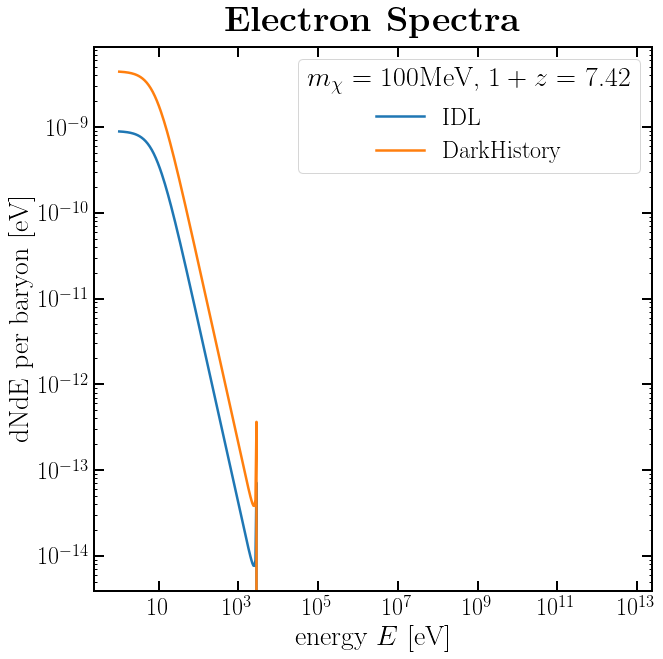

In [692]:
ind=3000
plt.figure()
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

elec_spectra.plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff')
a1[4].plot(ax=ax, ind=rs_list[ind], indtype='rs', label='stuff2', fac=1)

plt.title(r'\bf{Electron Spectra}')
plt.xlabel(r'energy $E$ [eV]')
plt.ylabel(r'dNdE per baryon [eV]')
leg = ax.legend(['IDL','DarkHistory'], title='$m_\chi$ = 100MeV, $1+z$ = '+str(round(rs_list[ind],2)), loc=1)
plt.setp(leg.get_title(),fontsize=28)
plt.savefig('/home/gridgway/Desktop/elec_spectra.png')
plt.show()

In [448]:
import darkhistory.low_energy as low_eng
ind=2100
mask = np.zeros_like(rs_list)
mask[ind]=1

mask2 = np.zeros_like(a1[3].rs)
mask2[ind]=1

tmp_phot = phot_spectra.sum_specs(mask)
tmp_phot2 = a1[3].sum_specs(mask2)

tmp_elec = phot_spectra.sum_specs(mask)
tmp_phot2 = a1[3].sum_specs(mask2)

fDH = low_eng.lowE_photons.compute_fs(
    tmp_phot2,
    np.array([1-data.field('hionfraction')[0], 0 ,0]),
    1,
    1
)

fIDL = low_eng.lowE_photons.compute_fs(
    tmp_phot,
    np.array([1-data.field('hionfraction')[0], 0 ,0]),
    1,
    1
)

print('IDL: ', fIDL, '\nDH: ', fDH)

IDL:  [-3.82317469e-12 -5.14115370e-13 -2.54895274e-12  0.00000000e+00
  0.00000000e+00] 
DH:  [-4.02419658e-12 -4.73993831e-13 -1.97800941e-12  0.00000000e+00
  0.00000000e+00]


In [ ]:
ind=2000

mask = np.zeros_like(rs_list)
mask[ind]=1

tmp_phot = phot_spectra.sum_specs(mask)
tmp_elec = elec_spectra.sum_specs(mask)

# Stop Hitting shift-enter now, Hongwan---------

[5, 2000.0, 1, 10000.0]

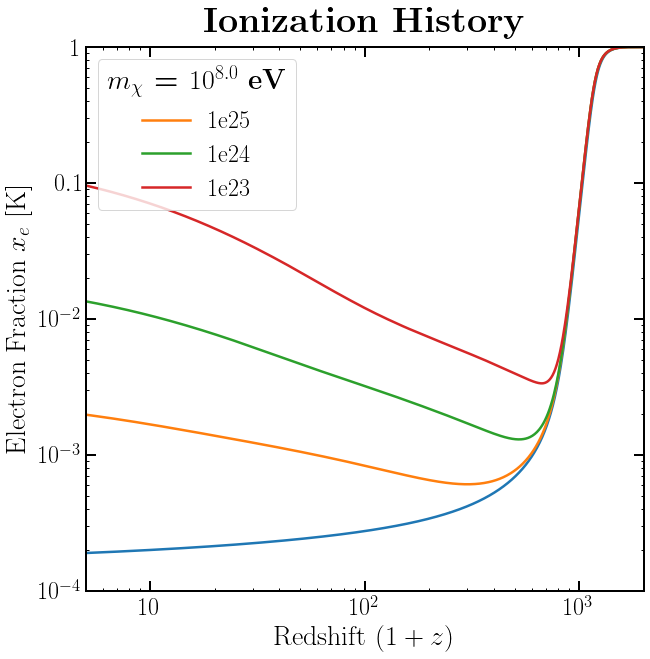

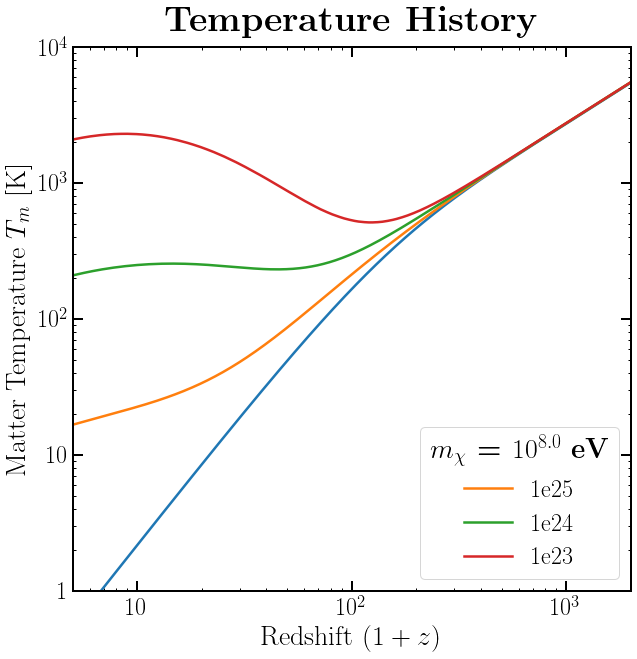

In [121]:
plt.figure()
plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
plt_3, = plt.plot(b3[3].rs, b3[0], label='1e25')
plt_2, = plt.plot(b2[3].rs, b2[0], label='1e24')
plt_1, = plt.plot(b1[3].rs, b1[0], label='1e23')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_3, plt_2, plt_1],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 1])
#plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

plt.figure()
plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
plt_T3, = plt.plot(b3[3].rs, b3[1]/phys.kB, label='1e25')
plt_T2, = plt.plot(b2[3].rs, b2[1]/phys.kB, label='1e24')
plt_T1, = plt.plot(b1[3].rs, b1[1]/phys.kB, label='1e23')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e4])
#plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

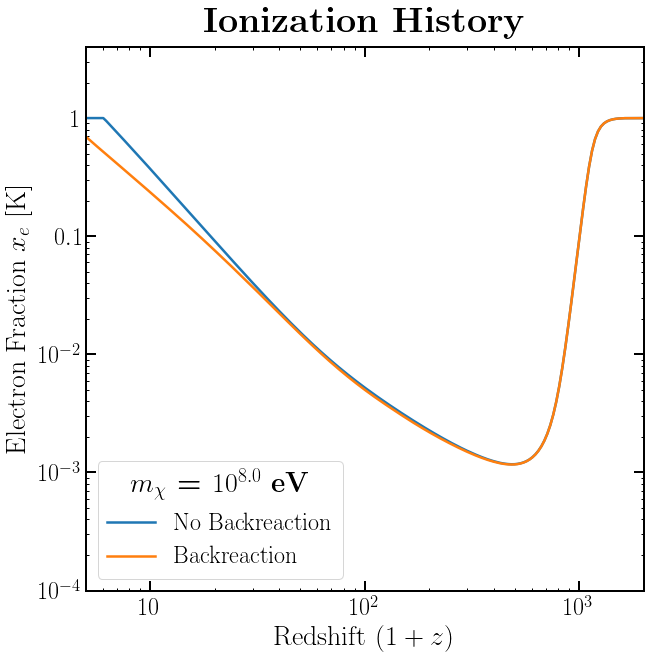

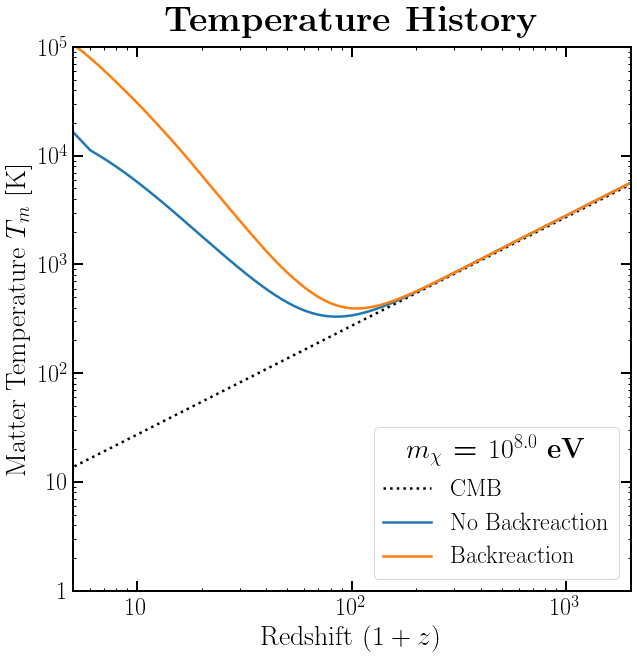

In [144]:
plt.figure()
plt_xe_std, = plt.plot(a[3].rs, a[0], label='No Backreaction')
plt_xe_backReact, = plt.plot(b[3].rs, b[0], label='Backreaction')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_xe_std, plt_xe_backReact],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=3
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 4])
plt.savefig('/home/gridgway/Desktop/xe_elec.png')

plt.figure()
plt_TCMB, = plt.plot(a[3].rs, phys.TCMB(a[3].rs)/phys.kB, 'k:', label='CMB')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='No Backreaction')
plt_Tm_backReact, = plt.plot(b[3].rs, b[1]/phys.kB, label='Backreaction')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_TCMB, plt_Tm_std, plt_Tm_backReact],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e5])
plt.savefig('/home/gridgway/Desktop/Tm_elec.png')

## Generate $f_c(z)$ contour plots

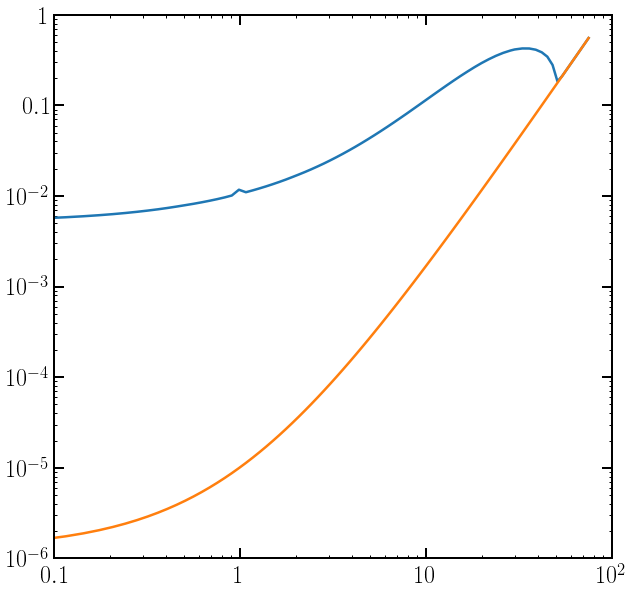

In [151]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(struct_data[:,0]-1, [np.sqrt(struct_boost(rs))*phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.plot(struct_data[:,0]-1, [phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.axis([1e-1, 1e2, 1e-6, 1])
plt.show()

In [23]:
fz_elec_decay = np.loadtxt('/home/gridgway/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0]

struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
def struct_boost(rs):
    if rs<76:
        return np.exp(log_struct_interp(np.log(rs)))
    else:
        return 1

def rate_func_decay_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/Ecom
def rate_func_decay_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau) 

def rate_func_swave_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
def rate_func_swave_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs) 

photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

In [714]:
%autoreload
inj_type='decay'
mDM=2*phys.me*1.01
end_rs = 5
Ecom=mDM
tau=1e26
phot_spec_init = Spectrum(photeng,
                         np.zeros_like(photeng),
                         spec_type='N',
                         rs=3000)
elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                  np.array([mDM/2-phys.me]), 
                                  eleceng)
elec_spec_init.rs = 3000
elec_spec_init.switch_spec_type()

data_elec = main.evolve(
    elec_spec_init, phot_spec_init*0,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=16, std_soln=True,
    reion_switch=False
)

TypeError: weight must be an ndarray or spectrum.

In [238]:
np.log10(highengphot_tf_interp.eng[-1])

12.728793934188179

### decay, photons

In [243]:
log10eng2 = np.linspace(3,np.log10(highengphot_tf_interp.eng[-1])-.01,160)

In [244]:
log10eng2

array([ 3.        ,  3.06112449,  3.12224898,  3.18337347,  3.24449796,
        3.30562245,  3.36674694,  3.42787143,  3.48899592,  3.55012041,
        3.6112449 ,  3.67236939,  3.73349388,  3.79461837,  3.85574286,
        3.91686735,  3.97799184,  4.03911633,  4.10024082,  4.16136531,
        4.2224898 ,  4.28361429,  4.34473878,  4.40586327,  4.46698776,
        4.52811225,  4.58923674,  4.65036123,  4.71148572,  4.77261021,
        4.8337347 ,  4.89485919,  4.95598368,  5.01710818,  5.07823267,
        5.13935716,  5.20048165,  5.26160614,  5.32273063,  5.38385512,
        5.44497961,  5.5061041 ,  5.56722859,  5.62835308,  5.68947757,
        5.75060206,  5.81172655,  5.87285104,  5.93397553,  5.99510002,
        6.05622451,  6.117349  ,  6.17847349,  6.23959798,  6.30072247,
        6.36184696,  6.42297145,  6.48409594,  6.54522043,  6.60634492,
        6.66746941,  6.7285939 ,  6.78971839,  6.85084288,  6.91196737,
        6.97309186,  7.03421635,  7.09534084,  7.15646533,  7.21

In [292]:
%autoreload
inj_type='decay'
end_rs = 5
sigmav = 3e-26#1e-26
f_decay_phot = []
for i,Einj in enumerate(tqdm(10**log10eng2)):
    mDM = 2*Einj
    Ecom = mDM
    tau = 1e25
    
    indTmp = spectools.get_indx(photeng,Einj)
    if photeng[indTmp] >= Einj:
        indTmp -= 1
    
    phot_spec_init = spectools.rebin_N_arr(
        np.array([mDM/photeng[indTmp]]),
        np.array([photeng[indTmp]]),
        photeng
    )
#     phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
#                                       np.array([Einj]), 
#                                       photeng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()
    elec_spec_init = 0*phot_spec_init

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        #ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        struct_boost=None,
        reion_switch=False
    )
    
    f_decay_phot.append(data_phot[5])

rs_list_phot = data_phot[3].rs
f_decay_phot = np.array(f_decay_phot)

pickle.dump(f_decay_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

In [294]:
pickle.dump(f_decay_phot, open("/home/gridgway/Desktop/f_contour_debug/fine_f_decay_phot.p", "wb"))

### decay, electrons

In [87]:
%autoreload
inj_type='decay'
end_rs = 5
sigmav = 3e-27#1e-26
f_decay_elec = []
for i,Einj in enumerate(tqdm(10**log10eng[:-1])):
    mDM = Einj*2 + phys.me*2
    Ecom=mDM
    tau=1e26
    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=3000)
    
    indTmp = spectools.get_indx(eleceng,Einj)
    if eleceng[indTmp] >= Einj:
        indTmp -= 1
    
    elec_spec_init = spectools.rebin_N_arr(
        np.array([mDM/eleceng[indTmp]]),
        np.array([eleceng[indTmp]]),
        eleceng
    )
#     elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
#                                       np.array([Einj]), 
#                                       eleceng)
    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=16, std_soln=True,
        reion_switch=False
    )
    
    f_decay_elec.append(data_elec[5])

rs_list_elec = data_elec[3].rs
f_decay_elec = np.array(f_decay_elec)

pickle.dump(f_decay_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "wb"))

### swave, photons

In [96]:
%autoreload
inj_type='swave'
end_rs = 5
sigmav = 1e-33#1e-26
tau=1e25
f_swave_phot = []
for i,Einj in enumerate(tqdm(10**log10eng2)):
    mDM = Einj
    Ecom=2*mDM
    
    indTmp = spectools.get_indx(photeng,Einj)
    if photeng[indTmp] >= Einj:
        indTmp -= 1
    
    phot_spec_init = spectools.rebin_N_arr(
        np.array([mDM/photeng[indTmp]]),
        np.array([photeng[indTmp]]),
        photeng
    )
#     phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
#                                       np.array([Einj]), 
#                                       highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()
    elec_spec_init = 0*phot_spec_init

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
#         ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=4, std_soln=True,
        struct_boost=struct_boost,
        reion_switch=False
    )
    
    f_swave_phot.append(data_phot[5])

rs_list_phot = data_phot[3].rs
f_swave_phot = np.array(f_swave_phot)

pickle.dump(f_swave_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot.p", "wb"))

### swave, electrons

In [95]:
%autoreload
inj_type='swave'
end_rs = 5
sigmav = 1e-33#1e-26
tau=1e24
f_swave_elec = []
for i,Einj in enumerate(tqdm(10**log10eng[:-1])):
    mDM = Einj + phys.me
    Ecom=2*mDM
    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=3000)
    
    indTmp = spectools.get_indx(eleceng,Einj)
    if eleceng[indTmp] >= Einj:
        indTmp -= 1
    
    elec_spec_init = spectools.rebin_N_arr(
        np.array([mDM/eleceng[indTmp]]),
        np.array([eleceng[indTmp]]),
        eleceng
    )
#     elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
#                                       np.array([Einj]), 
#                                       eleceng)
    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=16, std_soln=True,
        struct_boost=struct_boost,
        reion_switch=False
    )

    f_swave_elec.append(data_elec[5])

rs_list_elec = data_elec[3].rs
f_swave_elec = np.array(f_swave_elec)

pickle.dump(f_swave_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [255]:
pickle.dump(f_swave_elec, open("/home/gridgway/Desktop/f_contour_debug/f_swave_elec.p", "wb"))
pickle.dump(f_swave_phot, open("/home/gridgway/Desktop/f_contour_debug/f_swave_phot.p", "wb"))
pickle.dump(f_decay_elec, open("/home/gridgway/Desktop/f_contour_debug/f_decay_elec.p", "wb"))
pickle.dump(f_decay_phot, open("/home/gridgway/Desktop/f_contour_debug/f_decay_phot.p", "wb"))

In [373]:
f_decay_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "rb"))
f_decay_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "rb"))
f_swave_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "rb"))
f_swave_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot.p", "rb"))

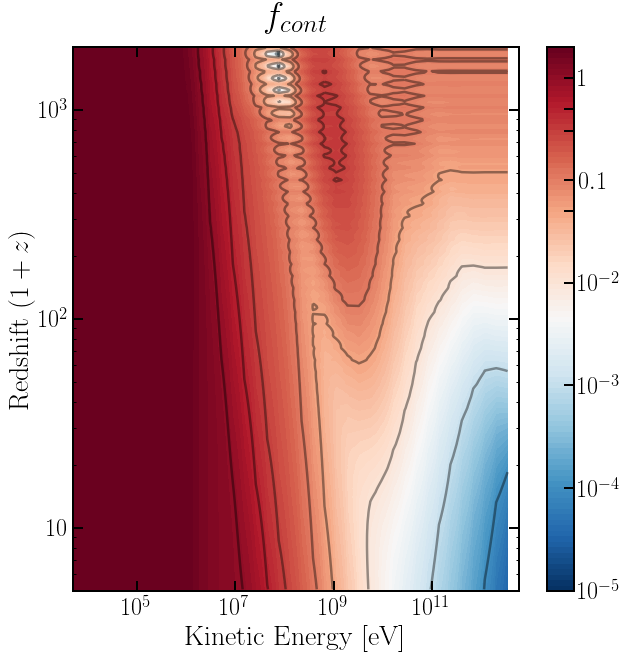

In [290]:
get_fcontour('decay','elec','cont')

In [279]:
def get_fcontour(inj_type, inj_particle, channel):
    eng=10**log10eng[:-1]
    if inj_particle is 'elec':
        coarsen_factor = 16

        if inj_type is 'decay':
            f_for_plot = f_decay_elec.copy()
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec.copy()
            folder='elec_swave/'
    else:
        coarsen_factor = 4

        if inj_type is 'decay':
            f_for_plot = f_decay_phot.copy()
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot.copy()
            folder='phot_swave/'

    rs_list = [3000*np.exp(-0.001*coarsen_factor*(i+1)) for i in np.arange(6400/coarsen_factor-1)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    elif inj_type is 'swave':
        if channel is 'H_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])
        elif channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([5e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 1e2, 3e2])
        elif channel is 'heat':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 3e1])
        elif channel is 'cont':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])
    
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_list,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,rs_list,
               np.transpose(f_for_plot[:,:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )
#     cbar = plt.colorbar(cs)
#     ax.loglog()
#     cs = ax.imshow(
#         np.transpose(f_for_plot[:,:,ind]),
#         interpolation='bilinear', cmap=matplotlib.cm.RdBu_r,
#         norm=matplotlib.colors.LogNorm(),
#         origin='lower', extent=[10**log10eng[0], 10**log10eng[-2], 5, 3e3]
# #                vmax=abs(f_for_plot[:,:,ind]).max(), vmin=-abs(f_for_plot[:,:,ind]).max()
#     )
#     cbar = plt.colorbar(cs)
#     plt.axis(aspect='image');
    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

    plt.savefig(
#         '/home/gridgway/Dropbox (MIT)/Photon Deposition/plots/f_contours/'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
        '/home/gridgway/Desktop/f_contour_debug/'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
    )



# Comparison to old results

# Import $f(z)$

In [233]:
f_heating(10,xe_std(10))

0.0001592616670604331

In [234]:
f_H_ion(54.947,xe_std(54.947))

0.005938699511868189

In [81]:
user = '/home/gridgway'
greg = ''

#---------- Decay ----------#
fz_elec_decay = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}


#---------- s-wave ----------#
fz_elec_swave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_elec_swave[0:70, 1]
log10eng = fz_elec_swave[0:2800:70, 0] 

log10f_elec_swave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_swave[11200:14000,2], (40,70))) 
}

fz_phot_swave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_phot_swave[0:70, 1]
log10eng = fz_phot_swave[0:2800:70, 0] 

log10f_phot_swave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_swave[11200:14000,2], (40,70)))
}

#---------- p-wave ----------#
fz_elec_pwave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_elec_pwave[0:70, 1]
log10eng = fz_elec_pwave[0:2800:70, 0] 

log10f_elec_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_pwave[11200:14000,2], (40,70))) 
}

fz_phot_pwave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_phot_pwave[0:70, 1]
log10eng = fz_phot_pwave[0:2800:70, 0] 

log10f_phot_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_pwave[11200:14000,2], (40,70)))
}


# Heating Processes

In [40]:
def compton_cooling_rate(xe, T_matter, rs):
    """Returns the Compton cooling rate. 

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    T_matter : float
        The matter temperature in eV. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Compton cooling rate in eV/s. 
    """
    return (
        xe / (1 + xe + phys.nHe/phys.nH) * (phys.TCMB(rs) - T_matter)
        * 32 * phys.thomson_xsec * phys.stefboltz
        * phys.TCMB(rs)**4 / (3 * phys.me)
    )

# Ionization Processes

In [41]:
def alpha_recomb(T_matter):
    """Case-B recombination coefficient. 

    Parameters
    ----------
    T_matter : float
        The matter temperature. 

    Returns
    -------
    float
        Case-B recombination coefficient in cm^3/s. 
    """ 
    
    # Fudge factor recommended in 1011.3758
    fudge_fac = 1.126

    return (
        fudge_fac * 1e-13 * 4.309 * (1.16405*T_matter)**(-0.6166)
        / (1 + 0.6703 * (1.16405*T_matter)**0.5300)
    )

def beta_ion(T_rad):
    """Case-B photoionization coefficient. 

    Parameters
    ----------
    T_rad : float
        The radiation temperature. 

    Returns
    -------
    float
        Case-B photoionization coefficient in s^-1. 

    """
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    return (
        (1/de_broglie_wavelength)**3/4 
        * np.exp(-phys.rydberg/4/T_rad) * alpha_recomb(T_rad)
    )

def peebles_C(xe, rs):
    """Returns the Peebles C coefficient. 

    This is the ratio of the total rate for transitions from n = 2 to the ground state to the total rate of all transitions, including ionization.

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    Tm : float
        The matter temperature. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Peebles C factor. 
    """

    # Net rate for 2p to 1s transition, times (1-xe). 
    rate_2p1s = (
        8 * np.pi * phys.hubble(rs)
        /(3*(phys.nH*rs**3 * (phys.c/phys.lya_freq)**3))
    )

    # Net rate for 2s to 1s transition, times (1-xe).
    rate_2s1s = phys.width_2s1s * (1-xe)

    # Net rate for ionization, times (1-xe).
    rate_ion = beta_ion(phys.TCMB(rs)) * (1-xe)

    # Rate is averaged over 3/4 of excited state being in 2p, 1/4 in 2s. 
    return (
        (3*rate_2p1s/4 + rate_2s1s/4)
        /(3*rate_2p1s/4 + rate_2s1s/4 + rate_ion)
    )

# TLA Differential Equation

In [42]:
import darkhistory.physics as phys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad

def get_history(
    init_cond, f_H_ion, f_H_exc, f_heating, 
    dm_injection_rate, dm_injection_param, rs_vec
):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    fz_H_ion : function
        f(xe, rs) for hydrogen ionization. 
    fz_H_exc : function
        f(xe, rs) for hydrogen Lyman-alpha excitation. 
    f_heating : function
        f(xe, rs) for heating. 
    dm_injection_rate : function
        Injection rate of DM as a function of redshift, and one parameter (lifetime or cross section). 
    dm_injection_param : float
        The injection parameter (lifetime or cross section).
    rs_vec : ndarray
        Abscissa for the solution. 

    Returns
    -------
    list of ndarray
        [temperature solution (in eV), xe solution]. 

    Note
    ----
    The actual differential equation that we solve is expressed in terms of y = arctanh(2*(xe - 0.5)). 

    """

    def tla_diff_eq(var, rs):
        # Returns an array of values for [dT/dz, dy/dz].
        # var is the [temperature, xe] inputs. 

        def xe(y):
            return 0.5 + 0.5*np.tanh(y)

        def dT_dz(T_matter, y, rs):
            #print(y)
            return (
                2*T_matter/rs - phys.dtdz(rs) * (
                    compton_cooling_rate(xe(y), T_matter, rs)
                    + (
                        1/(1 + xe(y) + phys.nHe/phys.nH)
                        * 2/(3 * phys.nH * rs**3)
                        * f_heating(rs, xe(y))
                        * dm_injection_rate(rs, dm_injection_param)
                    )
                )
            )

        def dy_dz(T_matter, y, rs):
            # Stops any change in y once it exceeds y = 4, or xe = 0.999665
            #print(rs, y)
            if y > 4 and rs < 100:
                return 0
            return (
                2 * np.cosh(y)**2 * phys.dtdz(rs) * (
                    peebles_C(xe(y), rs) * (
                        alpha_recomb(T_matter) * xe(y)**2 * phys.nH * rs**3
                        - (
                            beta_ion(phys.TCMB(rs)) * (1 - xe(y))
                            * np.exp(-phys.lya_eng/T_matter)
                        )
                    )
                    - (
                        f_H_ion(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param)
                        / (phys.rydberg * phys.nH * rs**3)
                    )
                    - (1 - peebles_C(xe(y), rs)) * (
                        f_H_exc(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param) 
                        / (phys.lya_eng * phys.nH * rs**3)
                    )
                )
            )

        T_matter, y = var[0], var[1]
        return [dT_dz(T_matter, y, rs), dy_dz(T_matter, y, rs)]

    mod_init_cond = np.array(init_cond)
    
    if mod_init_cond[1] == 1:
        mod_init_cond[1] = 1 - 1e-12
    
    mod_init_cond[1] = np.arctanh(2*(mod_init_cond[1] - 0.5))

    soln = odeint(tla_diff_eq, mod_init_cond, rs_vec)

    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])

    return soln

# TLA Full Solution

In [71]:
logmDM = 8
mDM = 10**logmDM
if np.log10(mDM) < 6:
    units = 'keV'
    mass = str(mDM/10**3)
elif np.log10(mDM) < 9:
    units = 'MeV'
    mass = str(mDM/10**6)
else:
    units = 'GeV'
    mass = str(int(mDM/10**9))

inj_type = 'decay'
#inj_param = 7e-29
prefactor = 1
exponent = -24
inj_param = prefactor * 10**exponent
#[-30.5, -30, -28.5, -27, -25.5]

# Set all of the fractions and DM injection functions.

def f_0(rs, xe):
    return np.zeros_like(rs)

def f_H_ion(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_ion'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_ion'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_H_exc(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_exc'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_exc'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_heating(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['heating'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['heating'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def dm_injection_rate(rs, param):
    if inj_type == 'decay':
        return phys.rho_DM*rs**3/param
    elif inj_type == 'swave':
        return phys.rho_DM**2*rs**6*param/mDM
    elif inj_type == 'pwave':
        sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
        return phys.rho_DM**2*rs**8*param/mDM*(sigma_1D_B/1e7)**2

rs_start = 3000
init_cond = [phys.TCMB(rs_start), 1]
rs_vec = np.flipud(1 + np.arange(0,rs_start-0.5,0.5))


inj_type = 'decay'
inj_param = 1e24

soln = get_history(init_cond, f_0, f_0, f_0, dm_injection_rate, inj_param, rs_vec)
soln_dec = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec)

[10, 2000.0, 1, 20000.0]

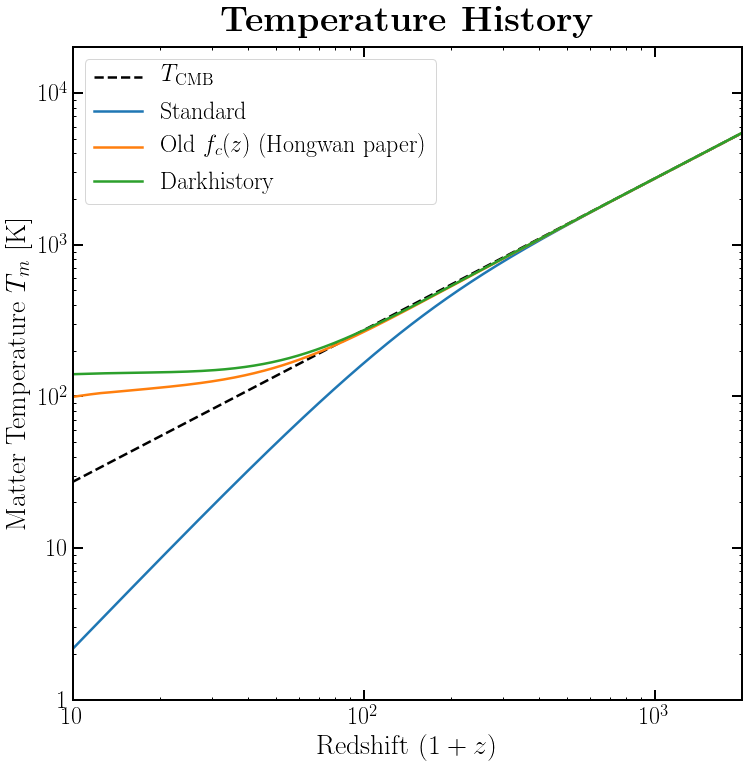

In [86]:
matplotlib.rcParams['figure.figsize'] = [12,12]
plt.figure()

ax = plt.gca()

T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')
T_IGM_std, = plt.plot(std_soln_rs, std_soln_T, label='Standard')
T_IGM_dec, = plt.plot(rs_vec, soln_dec[:,0]/phys.kB, alpha=1.0, label=r'Old $f_c(z)$ (Hongwan paper)')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='Darkhistory')

ax.set_xscale('log')
ax.set_yscale('log')

leg = plt.legend(handles=[T_CMB, T_IGM_std, T_IGM_dec, plt_Tm_std], 
                 #title=r'$m_\chi$\bf{ = '+mass+' '+units+' }',#$(1+z)_\mathrm{td} = 500$',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([10, 2e3, 1, 2e4])

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/T_standard_dec_swave_pwave_constraint.pdf')

# TeVPA Plotting

In [18]:
#Download tau_min and sigma_max

user = 'gridgway'
f_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def max_xsec_elec_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))
    elif injection_type == 'decay':
        return decay_elec_CMB(mDM*1e-9)

def max_xsec_phot_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))
    elif injection_type == 'decay':
        return decay_phot_CMB(mDM*1e-9)

### Single Temperature History

In [39]:
%autoreload
global user 
user = "gridgway"
end_rs = 5
mDM = 1e8
sigmav = max_xsec_phot_CMB(mDM, 'swave')
tau = max_xsec_phot_CMB(mDM, 'decay')


phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)

#!!! What about Reionization
std_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True, user="gridgway"
)

backReact_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=False, user="gridgway"
)

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


[None, None]

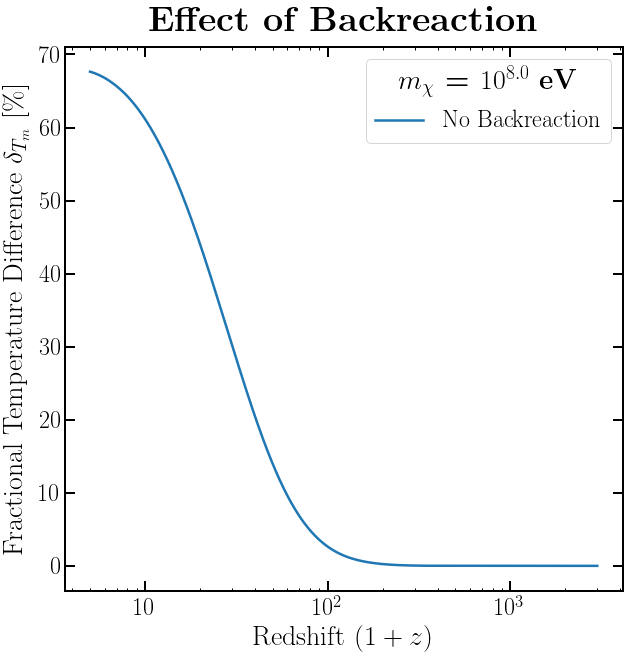

In [50]:
plt.figure()
plt_Tm_diff, = plt.plot(
    std_data[3].rs, np.abs((std_data[1]-backReact_data[1])/std_data[1] * 100), 
    label='No Backreaction'
)

ax = plt.gca()
ax.set_xscale('log')
#ax.set_yscale('log')

plt.title(r'\bf{Effect of Backreaction}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Fractional Temperature Difference $\delta_{T_m}$ [\%]')
leg2 = plt.legend(handles=[plt_Tm_diff],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=1
                 )
plt.setp(leg2.get_title(),fontsize=28)

### rs vs. mDM heat plot of differences

In [62]:
%autoreload

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]

end_rs = 5

diff_list = []

log10eng = log10eng[2:]

for i,mDM in enumerate(tqdm(10**log10eng)):
    sigmav = max_xsec_phot_CMB(mDM, 'swave')
    tau = max_xsec_phot_CMB(mDM, 'decay')
    
    def rate_func_decay_N(rs):
        # This is dN/dV dt
        return phys.inj_rate('decay', rs, tau=tau)/mDM

    def rate_func_decay_eng(rs):
        # This is dN/dV dt
        return phys.inj_rate('decay', rs, tau=tau)
    
    phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()

    a = main.evolve(
        phot_spec_init*0, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
        coarsen_factor=1, std_soln=True, user="gridgway"
    )
    
    b = main.evolve(
        phot_spec_init*0, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
        coarsen_factor=1, std_soln=False, user="gridgway"
    )
    
    diff_list.append(np.abs((a[1]-b[1])/a[1] * 100))

rs_list = a[3].rs
diff_list = np.array(diff_list)

if(species=='elec'):
    pickle.dump(diff_list, open("/Users/gridgway/Dropbox (MIT)/Photon Deposition/backReact_elec_residuals.p", "wb"))
else:
    pickle.dump(diff_list, open("/Users/gridgway/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals.p", "wb"))

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


Text(0.5,0,'Dark Matter Mass $m_\\chi$ [eV]')

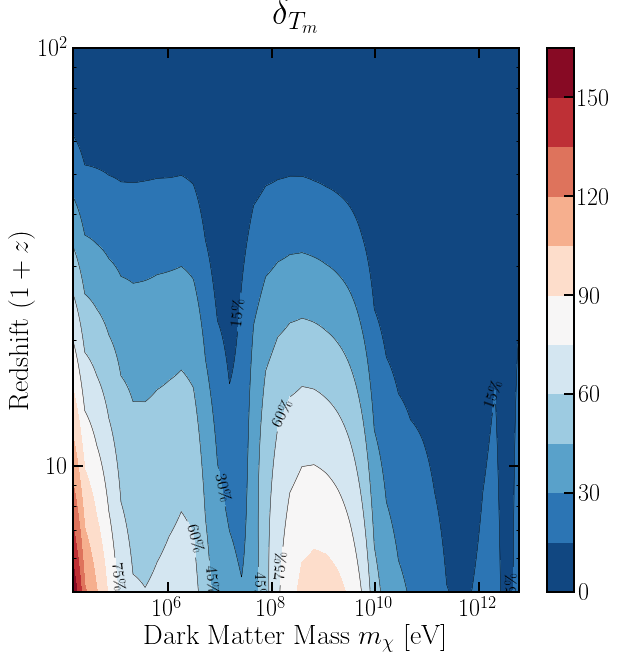

In [19]:
user = 'hongwan'

diff_list = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals.p', "rb"))

rs_list = np.exp(np.arange(np.log(3000), np.log(5), step=-0.002))

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]
log10eng = log10eng[2:]


plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(diff_list),
    levels=[15, 30, 45, 60, 75],
    linewidths=0.5,
    colors='k'
#     colors=[
#         (0/256,0,256/256),
#         (106/256,0,150/256),
#         (156/256,0,100/256),
#         (206/256,0,50/256), 
#         (256/256,0,0/256)
#     ]
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 100])

labels = { 
    15:r'$15$\%', 
    30:r'$30$\%',
    45:r'$45$\%',
    60:r'$60$\%',
    75:r'$75$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)
cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(diff_list), 14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=ax)

plt.title(r'\bf{$\delta_{T_m}$}')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

# user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')

In [17]:
plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(diff_list),
    levels=[15, 30, 45, 60, 75],
    linewidths=0.5,
    colors='k'
#     colors=[
#         (0/256,0,256/256),
#         (106/256,0,150/256),
#         (156/256,0,100/256),
#         (206/256,0,50/256), 
#         (256/256,0,0/256)
#     ]
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 100])

labels = { 
    15:r'$15$\%', 
    30:r'$30$\%',
    45:r'$45$\%',
    60:r'$60$\%',
    75:r'$75$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)
cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(diff_list), 14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=ax)

plt.title(r'\bf{$\delta_{T_m}$}')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

# user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')

(3199,)

# Coarsening

In [57]:
%%prun

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
 

In [59]:
74.2/24.7

3.0040485829959516

In [62]:
%%prun

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 16")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 16
 

In [53]:
%autoreload
%time
end_rs = 5
std_soln=True

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

a2 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=2, std_soln=std_soln
)
print("coarsen 2")

a4 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 4")

a8 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=8, std_soln=std_soln
)
print("coarsen 8")

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=16, std_soln=std_soln
)
print("coarsen 16")

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
coarsen 2
coarsen 4
coarsen 8
coarsen 16
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 4.77 µs


[None, None]

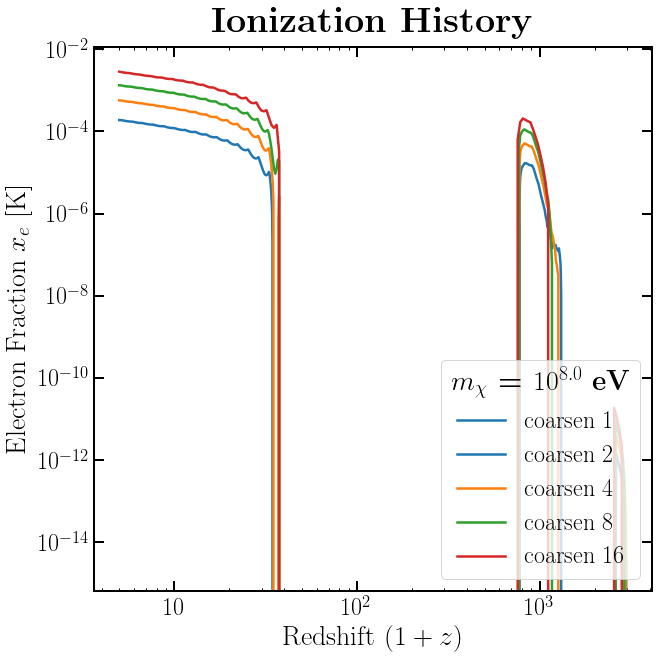

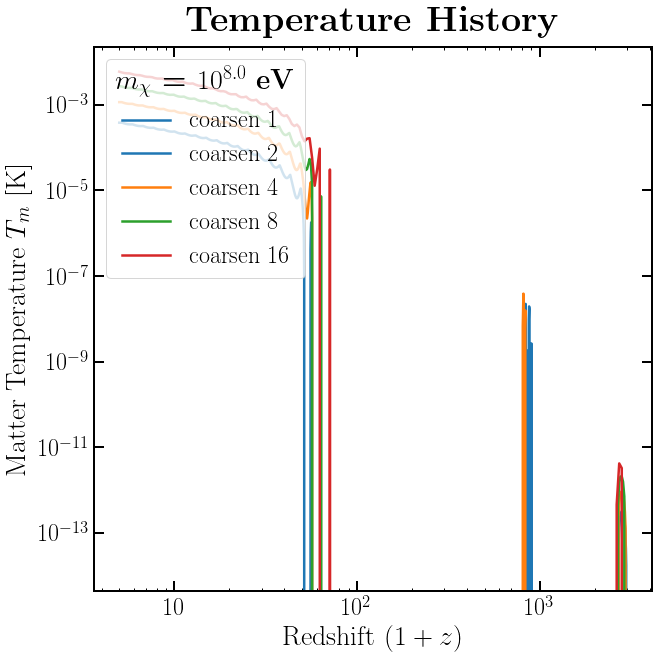

In [56]:
plt.figure()
#plt_1,  = plt.plot(a1[3].rs,  a1[0],  label='coarsen 1')
plt_2,  = plt.plot(a2[3].rs,  (a2[0]-a1[0][::2])/a2[0],  label='coarsen 2')
plt_4,  = plt.plot(a4[3].rs,  (a4[0]-a1[0][::4])/a4[0],  label='coarsen 4')
plt_8,  = plt.plot(a8[3].rs,  (a8[0]-a1[0][::8])/a8[0],  label='coarsen 8')
plt_16, = plt.plot(a16[3].rs, (a16[0]-a1[0][::16])/a16[0], label='coarsen 16')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_1, plt_2, plt_4, plt_8, plt_16],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=4
                )
plt.setp(leg.get_title(),fontsize=28)

plt.figure()
# plt_T1,  = plt.plot(a1[3].rs,  a1[1],  label='coarsen 1')
plt_T2,  = plt.plot(a2[3].rs,  (a2[1]-a1[1][::2])/a2[1],  label='coarsen 2')
plt_T4,  = plt.plot(a4[3].rs,  (a4[1]-a1[1][::4])/a4[1],  label='coarsen 4')
plt_T8,  = plt.plot(a8[3].rs,  (a8[1]-a1[1][::8])/a8[1],  label='coarsen 8')
plt_T16, = plt.plot(a16[3].rs, (a16[1]-a1[1][::16])/a16[1], label='coarsen 16')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T1, plt_T2, plt_T4, plt_T8, plt_T16],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=2
                 )
plt.setp(leg2.get_title(),fontsize=28)

# Scratch Work

In [408]:
f_decay_phot[9][:25]

array([[ 2.26818545e-02,  1.14536238e-12,  2.73074489e-02,
         2.53877560e-02, -4.48409057e-02],
       [ 4.14194560e-02,  2.17132551e-12,  5.21696956e-02,
         4.93899494e-02,  8.41129582e-02],
       [ 5.19684191e-02,  2.94841465e-12,  6.78175904e-02,
         7.01919493e-02,  1.84912274e-01],
       [ 5.77483890e-02,  3.59475460e-12,  7.74290210e-02,
         8.86007636e-02,  2.62000878e-01],
       [ 6.07820331e-02,  4.17172319e-12,  8.31622224e-02,
         1.05001337e-01,  3.19848384e-01],
       [ 6.22485035e-02,  4.70928100e-12,  8.64417878e-02,
         1.19593015e-01,  3.62513630e-01],
       [ 6.28268328e-02,  5.22041062e-12,  8.81873716e-02,
         1.32508454e-01,  3.93465660e-01],
       [ 6.29040260e-02,  5.70922983e-12,  8.89823186e-02,
         1.43866862e-01,  4.15552251e-01],
       [ 6.26987505e-02,  6.17550251e-12,  8.91915380e-02,
         1.53792911e-01,  4.31045132e-01],
       [ 6.23336867e-02,  6.61713832e-12,  8.90408223e-02,
         1.62419388e-01

In [644]:
direc='/home/gridgway/Desktop/DH_Data/'
#TEMPORARY
hdul = fits.open(
#     '/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'+
    direc+'tf_z_3.000E+03_nstep_6398_logE_5.764E+00_xe_0.000E+00.fits'
#     'tf_z_3.000E+03_nstep_3_logE_5.764E+00_xe_0.000E+00.fits'
)
data = hdul[1].data

# highengphot_tflist_arr = pickle.load(open(direc+"tfunclist_photspec_60eV_complete.raw", "rb"))

In [645]:
#TEMPORARY
rs_tmp = data.field('redshift')[0,0]
xe_tmp = data.field('hionfraction')[0,0]
E_tmp = data.field('mwimp')[0]

rs_list = data.field('redshift')[0]
highengphots = data.field('photonspectrum')[0]
lowengphots = data.field('lowengphot')[0]
lowengelecs = data.field('lowengelec')[0]

xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

In [646]:
photeng=highengphot_tf_interp.eng

indTmp = spectools.get_indx(photeng, E_tmp)
if photeng[indTmp] > E_tmp:
    indTmp -= 1

In [647]:
#Redshifts to be checked
# entries = np.arange(1)+500#np.array([2, 100, 1000, 2000])
# entries = np.arange(100,len(rs_list),4)
entries = np.array([0])
print('redshifts:', rs_list[entries])
print('tau:', 1/data.field('sigmav')/(phys.rho_crit*phys.omega_DM/E_tmp))

redshifts: [3000.]
tau: [1.00952277e+25]


In [648]:
data.field('cmblosstable')[0][1]

1.6452291540562456e-16

In [658]:
tau=1e25
CMB_engloss_interp.get_val(xe=1, rs=3000)[indTmp]*(
    2* E_tmp/photeng[indTmp] * phys.inj_rate(
        'decay', mDM=E_tmp, tau=tau, rs=3000
    )/E_tmp * .001/phys.hubble(3000) / phys.nB / 3000**3
)

1.6272044219389648e-16

In [652]:
CMB_engloss_interp.get_val(xe=data.field('hionfraction')[0][0], rs=3000)[indTmp]*(
    2*E_tmp/photeng[indTmp] * (
        data.field('annrate')[0][0]
    ) * .001/data.field('hubblerate')[0][0]
)

1.6453078592774784e-16

In [620]:
highengphot_tf_interp.rs

array([   4.        ,    4.56626611,    5.21269655,    5.9506399 ,
          6.79305133,    7.75472002,    8.85252881,   10.10575058,
         11.5363866 ,   13.16955279,   15.03392065,   17.1622206 ,
         19.59181658,   22.36536203,   25.53154867,   29.14596137,
         33.27205392,   37.98226307,   43.35928017,   49.49750292,
         56.50469254,   64.50386567,   73.63545397,   84.05976951,
         95.95981921,  109.54451763,  125.05235464,  142.75558229,
        162.9649944 ,  186.03538282,  212.37176602,  242.43649955,
        276.75739302,  315.93697621,  360.66307695,  411.72089648,
        470.00679424,  536.54402417,  612.50069871,  699.21029593,
        798.19506977,  911.19277434, 1040.18717161, 1187.44285781,
       1355.54502022, 1547.44482208, 1766.51121258, 2016.59007136,
       2302.07172587, 2627.96802697, 3000.00033585])

In [657]:
import darkhistory.history.histools as ht

photeng = highengphot_tf_interp.eng
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

rs_list = highengphot_tf_interp.rs
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

direc='/home/gridgway/Dropbox (MIT)/Photon Deposition/tflists/complete/'
CMB_engloss_arr = pickle.load(open(direc+"CMB_engloss_60eV_complete.raw", "rb"))
CMB_engloss_arr = np.swapaxes(CMB_engloss_arr, 1, 2)
tmp = np.zeros((len(xes),len(rs_list), len(photeng)))

for i, engloss in enumerate(CMB_engloss_arr):
    tmp[i] = np.pad(engloss, ((0,0), (photeng_low.size, 0)), 'constant')
CMB_engloss_arr = tmp.copy()

CMB_engloss_interp    = ht.IonRSInterp(xes, rs_list, CMB_engloss_arr, in_eng = photeng, logInterp=True)

In [660]:
rs_vec

array([2988.02396803, 2976.09574451, 2964.21513859, 2952.38196017,
       2940.59601992, 2928.85712927, 2917.1651004 , 2905.51974624,
       2893.92088045, 2882.36831746, 2870.86187242, 2859.40136123,
       2847.98660053, 2836.61740767, 2825.29360075, 2814.01499859,
       2802.78142073, 2791.59268743, 2780.44861968, 2769.34903916,
       2758.29376829, 2747.28263017, 2736.31544864, 2725.39204821,
       2714.51225411, 2703.67589226, 2692.88278929, 2682.1327725 ,
       2671.42566989, 2660.76131015, 2650.13952265, 2639.56013743,
       2629.02298524, 2618.52789747, 2608.0747062 , 2597.66324418,
       2587.29334483, 2576.96484222, 2566.67757111, 2556.4313669 ,
       2546.22606564, 2536.06150405, 2525.93751951, 2515.85395001,
       2505.81063423, 2495.80741148, 2485.8441217 , 2475.92060548,
       2466.03670403, 2456.19225923, 2446.38711356, 2436.62111014,
       2426.8940927 , 2417.20590562, 2407.55639389, 2397.94540311,
       2388.37277951, 2378.83836992, 2369.3420218 , 2359.88358

In [661]:
rs_vec = np.array([3000*np.exp(-0.001*4*(i+1)) for i in np.arange(6400/4-1)])[:100]
[(rs, CMB_engloss_interp.get_val(xe=xe_std(rs), rs=rs)[indTmp]*(
    2* E_tmp/photeng[indTmp] * phys.inj_rate(
        'decay', mDM=E_tmp, tau=tau, rs=rs
    )/E_tmp * .001/phys.hubble(rs) / phys.nB / rs**3
))
 for rs in rs_vec]

[(2988.0239680319746, 1.617527618473085e-16),
 (2976.095744511182, 1.6079052073380152e-16),
 (2964.2151385857915, 1.59833690434965e-16),
 (2952.3819601658556, 1.5888224266895398e-16),
 (2940.596019920266, 1.5793614928987142e-16),
 (2928.857129273728, 1.5699538228715587e-16),
 (2917.1651004037403, 1.5605991378496486e-16),
 (2905.5197462375927, 1.5512971604157128e-16),
 (2893.920880449369, 1.542047614487528e-16),
 (2882.3683174569696, 1.532850225311924e-16),
 (2870.86187241914, 1.5237047194587517e-16),
 (2859.4013612325143, 1.514610824814931e-16),
 (2847.9866005286685, 1.505568270578472e-16),
 (2836.617407671189, 1.4965767872526043e-16),
 (2825.293600752746, 1.4876361066398214e-16),
 (2814.0149985921885, 1.4787459618360866e-16),
 (2802.7814207316405, 1.469906087224935e-16),
 (2791.5926874336174, 1.4611162184717076e-16),
 (2780.4486196781468, 1.4523760925177495e-16),
 (2769.349039159907, 1.443685447574649e-16),
 (2758.293768285374, 1.4350440231185318e-16),
 (2747.282630169977, 1.426451559

In [510]:
#fs from idl run
entries=np.arange(100)
%autoreload
from darkhistory.low_energy import lowE_deposition as lowE_dep
idl_flist = [
    lowE_dep.compute_fs(
        phot_spec=Spectrum(data.field('energy')[0], phot, rs=rs),
        elec_spec=Spectrum(data.field('eleceng')[0], elec, rs=rs),
        x = np.array([1-xe, 0, 0]),
        dt = .001/hub,
#         highengdep = highdep_interps.get_val(xe, rs)[indTmp],
        highengdep = highdeposited,
        cmbloss = loss,
#         dE_dVdt_inj = phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)*2
        dE_dVdt_inj = 2*E_tmp*rate*phys.nB*rs**3
    )
    for xe, rs, phot, elec, loss, hub, rate, highdeposited in zip(data.field('hionfraction')[0][entries], 
                                   data.field('redshift')[0][entries], 
                                   data.field('lowengphot')[0][entries],
                                   data.field('lowengelec')[0][entries],
                                   data.field('cmblosstable')[0][entries],
                                   data.field('hubblerate')[0][entries],
                                   data.field('annrate')[0][entries],
                                   np.transpose(data.field('highdeposited_grid')[0][:,entries]))]

idl_flist=np.array(idl_flist)
# print(idl_flist)
# print(np.sum(idl_flist))

In [512]:
np.append(np.array([0,1,2]), 3)

array([0, 1, 2, 3])

In [511]:
idl_flist[:10,4]

array([ 0.        , -0.16132469, -0.11942163, -0.07943764, -0.04135207,
       -0.00513233,  0.02925999,  0.06187216,  0.09275713,  0.1219682 ])

In [447]:
data.field('cmblosstable')[0][:10]

array([0.00000000e+00, 1.64522915e-16, 3.26193409e-16, 4.84676583e-16,
       6.39673928e-16, 7.90923587e-16, 9.38198784e-16, 1.08130576e-15,
       1.22008465e-15, 1.35440524e-15])

In [353]:
f_cont(data.field('redshift')[0][3], E_tmp)

0.5366180306446543

In [355]:
data.field('redshift')[0][:6]

array([3000.        , 2997.0014995 , 2994.005996  , 2991.01348651,
       2988.02396803, 2985.03743758])

In [363]:
10**log10eng[9]/E_tmp

1.064700635322978

In [406]:
a1[5]

array([[2.82816790e-02, 9.70003871e-11, 9.70003871e-11, 9.70003871e-01,
        9.70003871e-11],
       [2.82816825e-02, 9.70003990e-11, 9.70003990e-11, 9.70003990e-01,
        9.70003990e-11],
       [2.82816859e-02, 9.70004109e-11, 9.70004109e-11, 9.70004109e-01,
        9.70004109e-11],
       [2.82816894e-02, 9.70004228e-11, 9.70004228e-11, 9.70004228e-01,
        9.70004228e-11],
       [2.82816929e-02, 9.70004347e-11, 9.70004347e-11, 9.70004347e-01,
        9.70004347e-11],
       [2.82816963e-02, 9.70004465e-11, 9.70004465e-11, 9.70004465e-01,
        9.70004465e-11],
       [2.82816998e-02, 9.70004584e-11, 9.70004584e-11, 9.70004584e-01,
        9.70004584e-11],
       [2.82817033e-02, 9.70004703e-11, 9.70004703e-11, 9.70004703e-01,
        9.70004703e-11],
       [2.82817067e-02, 9.70004822e-11, 9.70004822e-11, 9.70004822e-01,
        9.70004822e-11],
       [2.82817102e-02, 9.70004941e-11, 9.70004941e-11, 9.70004941e-01,
        9.70004941e-11],
       [2.82817137e-02, 9.7000

In [456]:
idl_flist[1:,4]

array([0.03925465, 0.07625766, 0.11106585, 0.14374642, 0.17437307,
       0.2030253 , 0.2297876 , 0.25474517, 0.27798723, 0.29960235,
       0.31967737, 0.33830133, 0.35555895, 0.37153254, 0.38630414,
       0.39994859, 0.41254264, 0.42415803, 0.43486091, 0.44471696,
       0.45378893, 0.4621315 , 0.46980154, 0.47684777, 0.48331782,
       0.48925903, 0.49471114, 0.49971406, 0.50430555, 0.50851612,
       0.5123795 , 0.51592373, 0.51917388, 0.52215718, 0.52489596,
       0.52740977, 0.52972094, 0.53184557, 0.53379941, 0.5355997 ,
       0.53725589, 0.53878435, 0.54019619, 0.5415    , 0.54270813,
       0.54382928, 0.54486997, 0.54583964, 0.54674095, 0.54758253,
       0.54837117, 0.54911007, 0.54980461, 0.55046072, 0.55107898,
       0.55166548, 0.55222187, 0.55275006, 0.55325497, 0.55373661,
       0.55419857, 0.55464413, 0.55507293, 0.55548719, 0.55588919,
       0.55627705, 0.55665553, 0.55702426, 0.55738333, 0.55773588,
       0.55808183, 0.5584207 , 0.55875504, 0.55908168, 0.55940

In [394]:
(f_decay_phot[9,:25,:]-idl_flist[3::4,:])/idl_flist[3::4,:]

array([[ 0.41133763,  0.38795376,  0.42841588,  0.35991366, -0.43343006],
       [ 0.10693   ,  0.12362472,  0.11656698,  0.13489494,  0.34151753],
       [ 0.05163356,  0.07304469,  0.05795729,  0.08265591,  0.04526397],
       [ 0.03191557,  0.05425167,  0.03578481,  0.05987886, -0.01960382],
       [ 0.0237626 ,  0.04516256,  0.0258079 ,  0.04709298, -0.05293032],
       [ 0.02061538,  0.0398062 ,  0.02120595,  0.03882517, -0.07554044],
       [ 0.01982446,  0.0360523 ,  0.01937374,  0.03298815, -0.09296127],
       [ 0.02026128,  0.03304818,  0.01897054,  0.02862882, -0.10721858],
       [ 0.02124163,  0.03042493,  0.01937762,  0.02524558, -0.11925922],
       [ 0.02250875,  0.02802602,  0.02015569,  0.02254909, -0.12954025],
       [ 0.02381524,  0.02577838,  0.02112337,  0.02035355, -0.13833151],
       [ 0.02510663,  0.0236542 ,  0.02210827,  0.0185348 , -0.14579145],
       [ 0.02629914,  0.02164173,  0.02305826,  0.01700442, -0.15205238],
       [ 0.02736237,  0.01973697,  0.0

In [358]:
#sum(fs) from 2016 paper
mathematica_flist = [
    np.array(
        [f_H_ion(rs,1),
         f_He_ion(rs,1),
         f_H_exc(rs,1),
         f_heating(rs,1),
         f_cont(rs,1)]
    )
for rs in rs_list[entries]]
mathematica_flist = np.array(mathematica_flist)

# print(mathematica_flist)
# print(np.sum(mathematica_flist))

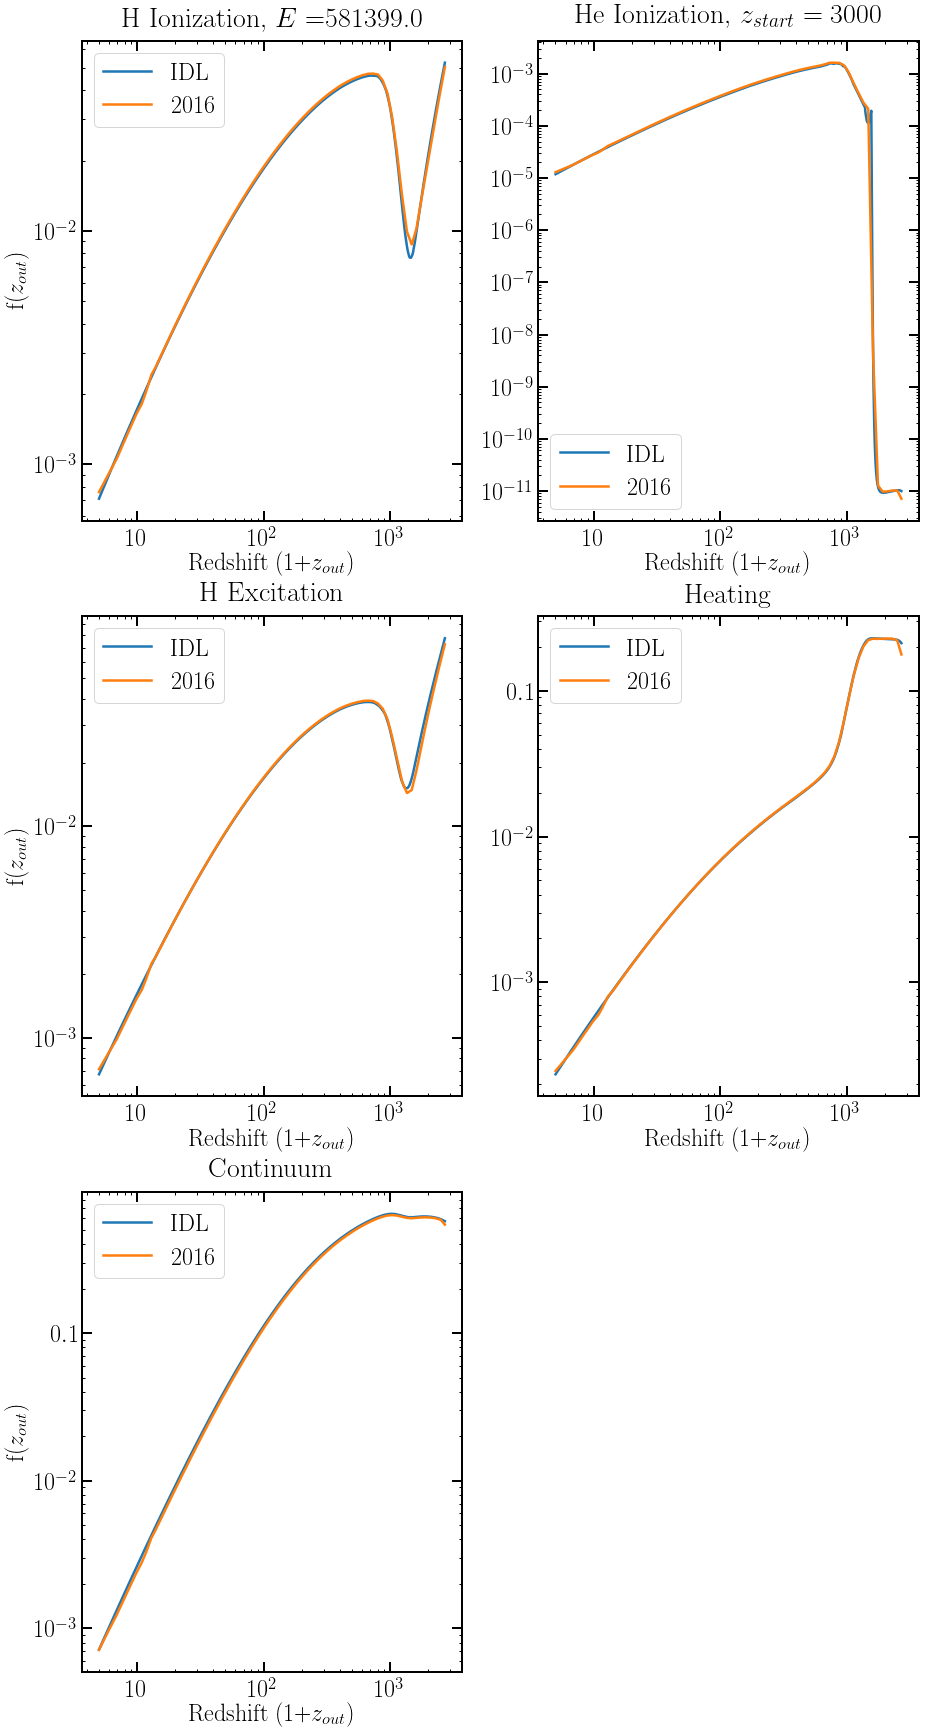

In [360]:
plt.figure(figsize=(15,30))

names = ["H Ionization", "He Ionization", "H Excitation", "Heating", "Continuum"]

for num in np.arange(5):

    ax = plt.subplot(3,2,num+1)
    ax.loglog()
    
    plt.plot(rs_list[entries], idl_flist[:,num])
    plt.plot(rs_list[entries], mathematica_flist[:,num])
    plt.legend(['IDL', '2016'])
    plt.title(names[num])

#     ref_tf_plt, = plt.plot(rs_list[:], f_ref[:,num], 'C1', linewidth=2, label='Reference File')
#     new_tf_plt0, = plt.plot(rs_list[:], f_list[:,num], 'C0--', label='DarkHistory')

#     plt.tick_params(axis='both', which='major', labelsize=20)

    if num == 0:
        plt.title(names[num]+', $E = $'+str(E_tmp), fontsize=28)
    elif num == 1:
        plt.title(names[num]+', $z_{start} = 3000$', fontsize=28)
    else:
        plt.title(names[num], fontsize=28)
    plt.xlabel('Redshift (1+$z_{out}$)',fontsize=24)
    if num%2 == 0:
        plt.ylabel('f($z_{out}$)',fontsize=24)
#         plt.legend(handles=[old_tf_plt, new_tf_plt0], 
#             fontsize=18)
#     plt.axis(
#         [0, 32, 0, 1.1 * max(
#             [max(f_list[:,num]),max(f_ref[:,num])]
#         )]
#     )

extra = 'DHv2'
plt.savefig('/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/f_IDL_vs_mathematica.pdf')
#plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/'+extra+
#            '_log10(E)_'+str(eng_exp)+'.pdf')

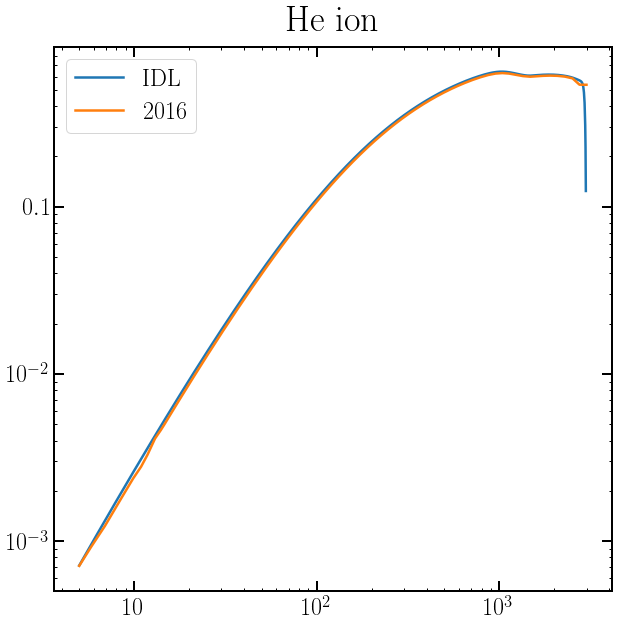

In [251]:
plt.figure()
ax = plt.gca()
ax.loglog()
chan_ind = 4



plt.show()

In [17]:
#TEMPORARY
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

In [577]:
#TEMPORARY
dlnz = 1e-3
nzsteps = 51
initredshift = 3000
finredshift = 4
lnzstep = (np.log(initredshift) - np.log(finredshift))/(nzsteps-1)
redshiftgrid = np.exp(np.log(4) + lnzstep*np.arange(nzsteps))

In [103]:
#TEMPORARY
mmin = 5e3
mmax = 1e13
nmwimpsteps = 40
nengsteps = 51
lowinjE = 60
mwimp = mmin*np.exp((np.arange(nmwimpsteps))*np.log(mmax/mmin)/nmwimpsteps)
mwimpmax = mwimp[-1]

injE = lowinjE*np.exp((np.arange(nengsteps)*np.log(mwimpmax/lowinjE)/nengsteps))
injE = np.insert(injE[1:] ,0, 61)

In [106]:
injE[-1]/1e12

3.5644894081221503

In [148]:
rsTmp=10
np.sum([
    f_H_ion(rsTmp,1),
    f_He_ion(rsTmp,1),
    f_H_exc(rsTmp,1),
    f_heating(rsTmp,1),
    f_cont(rsTmp,1)
])

0.0062153351388832857

In [60]:
utils.compare_arr([a1[5][200:,4],mathematica_flist[:-1,4]])

[[ 0.53355914  0.58994547]
 [ 0.53367782  0.59010106]
 [ 0.53382712  0.59025669]
 ..., 
 [ 0.60252961  0.62900322]
 [ 0.60164816  0.62896266]
 [ 0.60078687  0.6289221 ]]


0

In [107]:
a1[5][:10,:]

array([[  1.09664764e-05,   8.89265204e-14,   1.00472218e-05,
          4.33990927e-03,  -1.60791408e-01],
       [  8.58562724e-03,   4.76180593e-13,   1.00709253e-02,
          1.16798129e-02,  -1.18540728e-01],
       [  1.60695878e-02,   8.25184832e-13,   1.91118802e-02,
          1.86437487e-02,  -7.83675677e-02],
       [  2.25942519e-02,   1.14137896e-12,   2.72238626e-02,
          2.52763229e-02,  -4.02438885e-02],
       [  2.82760566e-02,   1.42946548e-12,   3.44914373e-02,
          3.16152146e-02,  -4.13107804e-03],
       [  3.32180329e-02,   1.69350343e-12,   4.09929377e-02,
          3.76921547e-02,   3.00181808e-02],
       [  3.75112271e-02,   1.93699090e-12,   4.68006767e-02,
          4.35337835e-02,   6.22582506e-02],
       [  4.12359923e-02,   2.16293742e-12,   5.19812004e-02,
          4.91624012e-02,   9.26490716e-02],
       [  4.44631583e-02,   2.37392751e-12,   5.65955717e-02,
          5.45966216e-02,   1.21254869e-01],
       [  4.72550878e-02,   2.5721763

In [109]:
a1[5][:10,:]

array([[  1.09884342e-05,   8.89265204e-14,   1.00672300e-05,
          4.34651792e-03,  -1.61212659e-01],
       [  8.58567146e-03,   4.76180593e-13,   1.00709656e-02,
          1.16931075e-02,  -1.19379470e-01],
       [  1.60696545e-02,   8.25184832e-13,   1.91119408e-02,
          1.86637877e-02,  -7.96191072e-02],
       [  2.25943412e-02,   1.14137896e-12,   2.72239437e-02,
          2.53031462e-02,  -4.19026759e-02],
       [  2.82761687e-02,   1.42946548e-12,   3.44915391e-02,
          3.16488441e-02,  -6.19078619e-03],
       [  3.32181678e-02,   1.69350343e-12,   4.09930601e-02,
          3.77325950e-02,   2.75645806e-02],
       [  3.75113847e-02,   1.93699090e-12,   4.68008195e-02,
          4.35810228e-02,   5.94184126e-02],
       [  4.12361726e-02,   2.16293742e-12,   5.19813637e-02,
          4.92164117e-02,   8.94312015e-02],
       [  4.44633612e-02,   2.37392751e-12,   5.65957552e-02,
          5.46573607e-02,   1.17667652e-01],
       [  4.72553130e-02,   2.5721763

In [102]:
utils.compare_arr([a1[3].rs[200:-1], idl_flist[:-1,3]/mathematica_flist[:-1,3]])#/a1[5][200:,3]])

[[  2.45373729e+03   1.00491774e+00]
 [  2.45128478e+03   1.00470796e+00]
 [  2.44883472e+03   1.00449395e+00]
 [  2.44638711e+03   1.00427554e+00]
 [  2.44394195e+03   1.00405351e+00]
 [  2.44149923e+03   1.00382763e+00]
 [  2.43905895e+03   1.00359795e+00]
 [  2.43662111e+03   1.00336498e+00]
 [  2.43418571e+03   1.00312801e+00]
 [  2.43175274e+03   1.00288777e+00]
 [  2.42932220e+03   1.00264441e+00]
 [  2.42689409e+03   1.00239766e+00]
 [  2.42446841e+03   1.00214798e+00]
 [  2.42204516e+03   1.00189620e+00]
 [  2.41962432e+03   1.00164171e+00]
 [  2.41720591e+03   1.00138479e+00]
 [  2.41478991e+03   1.00112507e+00]
 [  2.41237632e+03   1.00086245e+00]
 [  2.40996515e+03   1.00059771e+00]
 [  2.40755639e+03   1.00033037e+00]
 [  2.40515004e+03   1.00006100e+00]
 [  2.40274609e+03   9.99788618e-01]
 [  2.40034455e+03   9.99512958e-01]
 [  2.39794540e+03   9.99235609e-01]
 [  2.39554866e+03   9.98956498e-01]
 [  2.39315430e+03   9.98674891e-01]
 [  2.39076235e+03   9.98392124e-01]
 

0

In [51]:
mathematica_flist[:,0]

array([ 0.03747068,  0.03735744,  0.03724455,  0.03713199,  0.03701978,
        0.0369079 ,  0.03679636,  0.03668516,  0.03657429,  0.03646376,
        0.03635357,  0.0362437 ,  0.03613417,  0.03602497,  0.0359161 ,
        0.03580756,  0.03569935,  0.03559146,  0.0354839 ,  0.03537666,
        0.03526975,  0.03516317,  0.0350569 ,  0.03495096,  0.03484533,
        0.03474003,  0.03463504,  0.03453037,  0.03442602,  0.03432198,
        0.03421825,  0.03411484,  0.03401175,  0.03390896,  0.03380648,
        0.03370432,  0.03360246,  0.03350091,  0.03339967,  0.03329873,
        0.0331981 ,  0.03309777,  0.03299775,  0.03289803,  0.03279861,
        0.03269949,  0.03260067,  0.03250215,  0.03240392,  0.03230599,
        0.03220836,  0.03211103,  0.03201398,  0.03191724,  0.03182078,
        0.03172461,  0.03162874,  0.03153316,  0.03143786,  0.03134285,
        0.03124813,  0.0311537 ,  0.03105955,  0.030963  ,  0.03086585,
        0.030769  ,  0.03067246,  0.03057622,  0.03048029,  0.03

In [48]:
mathematica_flist = [
    np.array(
        [f_H_ion(rs,1),
         f_He_ion(rs,1),
         f_H_exc(rs,1),
         f_heating(rs,1),
         f_cont(rs,1)]
    )
for rs in a1[3].rs[200:]]
mathematica_flist = np.array(mathematica_flist)

In [552]:
entries = np.arange(1000)

In [553]:
from darkhistory.low_energy import lowE_deposition as lowE_dep
idl_flist = [
    lowE_dep.compute_fs(
        phot_spec=Spectrum(data.field('energy')[0], phot, rs=rs),
        elec_spec=Spectrum(data.field('eleceng')[0], elec, rs=rs),
        x = np.array([1-xe, 0, 0]),
        dt = .001/hub,
#         highengdep = highdep_interps.get_val(xe, rs)[indTmp],
        highengdep = highdeposited,
        cmbloss = loss,
        dE_dVdt_inj = phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)*2
#         dE_dVdt_inj = 2*mwimp*rate*phys.nB*rs**3
    )
    for xe, rs, phot, elec, loss, hub, rate, highdeposited in zip(data.field('hionfraction')[0][entries], 
                                   data.field('redshift')[0][entries], 
                                   data.field('lowengphot')[0][entries],
                                   data.field('lowengelec')[0][entries],
                                   data.field('cmblosstable')[0][entries],
                                   data.field('hubblerate')[0][entries],
                                   data.field('annrate')[0][entries],
                                   np.transpose(data.field('highdeposited_grid')[0][:,entries]))
]

idl_flist=np.array(idl_flist)

In [115]:
%autoreload
coarsen_factor = 4

tau=1e25
a2 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
#     ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
    coarsen_factor=coarsen_factor, std_soln=std_soln,
    struct_boost=None, verbose=True
)

completed rs:  3000.0
completed rs:  2988.02396803
completed rs:  2976.09574451
completed rs:  2964.21513859
completed rs:  2952.38196017
completed rs:  2940.59601992
completed rs:  2928.85712927
completed rs:  2917.1651004
completed rs:  2905.51974624
completed rs:  2893.92088045
completed rs:  2882.36831746
completed rs:  2870.86187242
completed rs:  2859.40136123
completed rs:  2847.98660053
completed rs:  2836.61740767
completed rs:  2825.29360075
completed rs:  2814.01499859
completed rs:  2802.78142073


In [149]:
tmp=np.array([a1[2][4*int(i)]+a1[2][4*int(i)+1]+a1[2][4*int(i)+2]+a1[2][4*int(i)+3] for i in np.arange(np.floor(len(a1[2].rs)/4))])
[np.dot(CMB_engloss_interp.get_val(xe_std(rs), rs), spec.N) for rs, spec in zip(a2[2].rs,tmp)]

[1.8581853149709092e-15,
 5.1142157121356749e-15,
 8.3186973486294936e-15,
 1.0935927693632034e-14,
 1.2654367507711179e-14,
 1.3532449284965521e-14,
 1.3913776754628122e-14,
 1.4219668956688391e-14]

In [152]:
tmp=np.array([a1[2][i] for i in np.arange(len(a1[2].rs))])
[np.dot(CMB_engloss_interp.get_val(xe_std(rs), rs), spec.N) for rs, spec in zip(a1[2].rs,tmp)][1:]

[3.6140627841305213e-16,
 5.5526860782629664e-16,
 7.55772219750139e-16,
 9.6101837210186297e-16,
 1.1689047087337312e-15,
 1.3772265112426783e-15,
 1.5836562836111958e-15,
 1.7858912472530326e-15,
 1.9816610340334365e-15,
 2.1688458278598382e-15,
 2.3455180486124669e-15,
 2.5100343701939607e-15,
 2.6610692384021723e-15,
 2.7976887956154e-15,
 2.9193494762554332e-15,
 3.0259418611313351e-15,
 3.1177541845057974e-15,
 3.1954605625942128e-15,
 3.2600719638146093e-15,
 3.3128690346285364e-15,
 3.3553455483328454e-15,
 3.3891352132912797e-15,
 3.4159467041206299e-15,
 3.4375132602678699e-15,
 3.4555500537684567e-15,
 3.4717217218723464e-15,
 3.4876272382961377e-15,
 3.5047932277206567e-15,
 3.52466984787827e-15,
 3.5486231741021965e-15,
 3.5779185147483382e-15,
 3.6136865536100085e-15,
 3.6568690006728313e-15,
 3.7081458662439051e-15]

In [120]:
print(a2[5])

[[  3.49400631e-02   2.01893645e-12   5.02115142e-02   3.80054540e-02
   -1.68168302e+00]
 [  5.01814757e-02   3.96467402e-12   8.43941537e-02   6.90830419e-02
   -1.40664619e+00]
 [  5.30215161e-02   6.41896889e-12   9.67872964e-02   1.04441395e-01
   -9.87948066e-01]
 [  5.30188725e-02   9.69446886e-12   1.00186669e-01   1.45133650e-01
   -5.12576857e-01]
 [  5.24761464e-02   1.36262924e-11   1.00478568e-01   1.88873491e-01
   -1.18795681e-01]
 [  5.18313141e-02   1.77013284e-11   9.97687869e-02   2.31636714e-01
    9.48629568e-02]
 [  5.11667175e-02   2.13957478e-11   9.87760642e-02   2.70172828e-01
    1.16817713e-01]
 [  5.05039185e-02   2.46879983e-11   9.77736497e-02   3.06317455e-01
   -1.89747855e-02]]


In [164]:
mathematica_flist[:,0].shape

(6398,)

In [165]:
utils.compare_arr([a1[5][:,0], mathematica_flist[1:-1,0]])

[[  5.07123809e-05   5.20693418e-02]
 [  1.51440708e-02   5.20693418e-02]
 [  2.65137513e-02   5.20693418e-02]
 ..., 
 [  1.42653037e-03   7.61147155e-04]
 [  1.42487506e-03   7.60362753e-04]
 [  1.42321478e-03   7.59579159e-04]]


0

In [158]:
#sum(fs) from 2016 paper
mathematica_flist = [
    np.array(
        [f_H_ion(rs,1),
         f_He_ion(rs,1),
         f_H_exc(rs,1),
         f_heating(rs,1),
         f_cont(rs,1)]
    )
for rs in a1[2].rs]
mathematica_flist = np.array(mathematica_flist)

# Checking Transfer Functions and f$_c$(z)

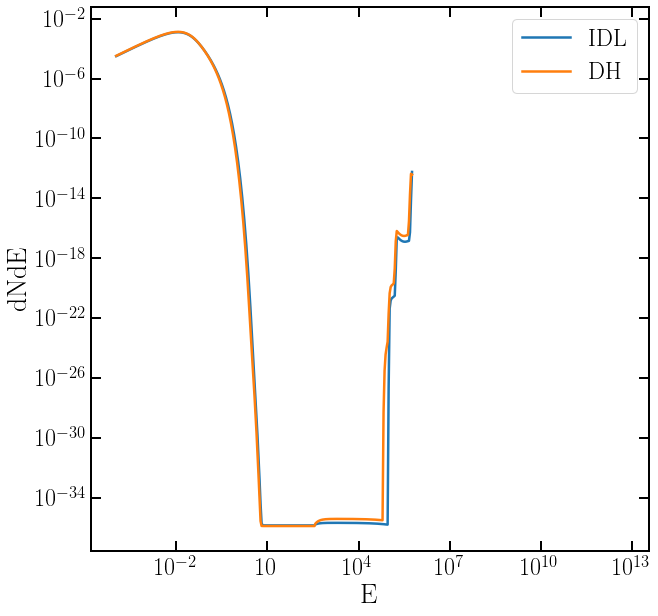

In [315]:
plt.plot()
ax=plt.gca()
ax.loglog()

plt.plot(photeng, data.field('photonspectrum')[0][2])
plt.plot(photeng, a1[2][1].dNdE)
plt.legend(['IDL', 'DH'])
plt.xlabel('E')
plt.ylabel('dNdE')

# plt.savefig('/Users/GregoryRidgway/Desktop/highengphot.png')
plt.show()

!!!! Include deposition from electron cooling processes

In [21]:
photeng = data.field('energy')[0]
eleceng = data.field('eleceng')[0]

In [384]:
# sum(fs) from idl run

tmp = [
    phys.nB*rs**3 * (phys.hubble(rs)/.001 *(
        Spectrum(data.field('energy')[0], phot, rs=rs).toteng(bound_type='eng', bound_arr=[1e-12, 10.2])
#         Spectrum(data.field('eleceng')[0], elec, rs=rs).toteng(bound_type='eng', bound_arr=[10.2, 13.6])
    ) - loss)/phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)/2
    for rs, phot, elec, loss, hub in zip(rs_list[entries], 
                                    lowengphots[entries],
                                    lowengelecs[entries],
                                    data.field('cmblosstable')[0][entries],
                                    data.field('hubblerate')[0][entries])
]
print(tmp)

[array([ 0.43022173])]


In [ ]:
tau=1e23
a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
    coarsen_factor=coarsen_factor, std_soln=std_soln,
    struct_boost=None
)
print('Done 1')
# tau = 1e24

# a2 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 2')
# tau=1e25

# a3 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 3')

# b = main.evolve(
#     phot_spec_init*0, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
#     coarsen_factor=1, std_soln=False
# )

In [668]:
# plt.figure()
# plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
# plt_3, = plt.plot(a3[3].rs, a3[0], label='1e25')
# plt_2, = plt.plot(a2[3].rs, a2[0], label='1e24')
# plt_1, = plt.plot(a1[3].rs, a1[0], label='1e23')

# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Ionization History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Electron Fraction $x_e$ [K]')
# leg = plt.legend(handles=[plt_3, plt_2, plt_1],
#                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                  loc=2
#                 )
# plt.setp(leg.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1e-4, 1])
# #plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

# plt.figure()
# plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
# plt_T3, = plt.plot(a3[3].rs, a3[1]/phys.kB, label='1e25')
# plt_T2, = plt.plot(a2[3].rs, a2[1]/phys.kB, label='1e24')
# plt_T1, = plt.plot(a1[3].rs, a1[1]/phys.kB, label='1e23')

# # plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Temperature History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Matter Temperature $T_m$ [K]')
# leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
#                   title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                   loc=4
#                  )
# plt.setp(leg2.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1, 1e4])
# #plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

[20000.0, 1000000000000.0, 6e+22, 1e+31]

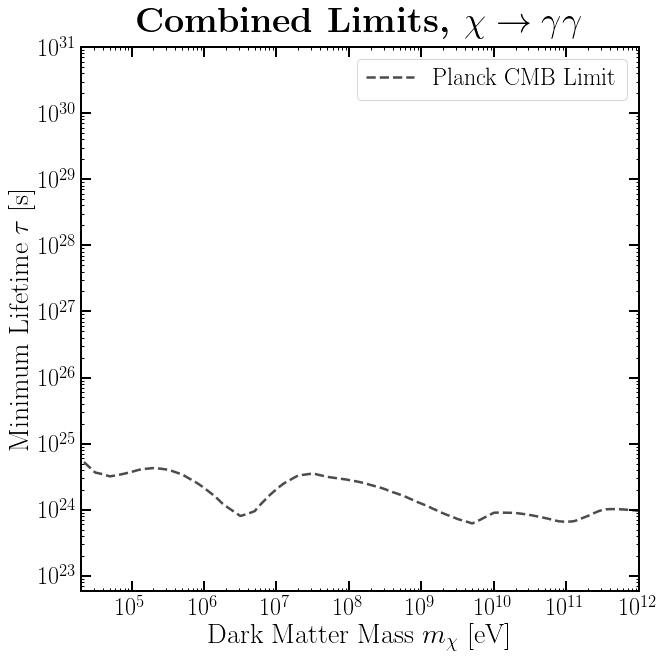

In [21]:
log10mDM_fine = np.log10(10**np.arange(4, 12.5, 0.05) + 2*phys.me*0)
log10tau_fine = np.arange(22, 30, 0.05)
lim_CMB, = plt.plot(
    10**log10mDM_fine, max_xsec_phot_CMB(10**log10mDM_fine, 'decay'), 
    color='black', alpha=0.7, linestyle='dashed'
)

lim_CMB.set_label(r'Planck CMB Limit')

leg = plt.legend(loc=1)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Combined Limits}, $\chi \to \gamma \gamma$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Minimum Lifetime $\tau$ [s]')
plt.axis([2e4, 1e12, 6e22, 1e31])

In [154]:
# p-wave structure formation
NFW_subs_data = []
with open('/home/gridgway/Dropbox (MIT)/21cm_pwave/math/data/rho_eff_NFW_subs_pwave.txt') as f:
    for line in f:
        inner_list = [float(num.strip()) for num in line.split(' ') if num]
        NFW_subs_data.append(inner_list)
        
NFW_subs_data = np.array(NFW_subs_data)
NFW_subs_data[:,2] *= .839418
NFW_subs_data[:,0] += 1
sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
NFW_subs_data[:,1] = phys.rho_DM * NFW_subs_data[:,0]**4 * 10**-9 * sigma_1D_B/phys.c

struct_boost_raw = (NFW_subs_data[:,2]/NFW_subs_data[:,1])**2

log10_struct_boost = interp1d(NFW_subs_data[:,0], np.log10(struct_boost_raw))

def struct_boost(rs):
    if rs < NFW_subs_data[-1,0]:
        return 10**log10_struct_boost(rs)
    else:
        return 1.

- RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded

- why are there fewer energy bins in CMB_engloss_arr than the tflists?

In [52]:
CMB_engloss_arr.shape

(11, 321, 51)

In [151]:
# Spectra of CMB as a function of rs
eng = a[3].eng
CMB_spectra = Spectra([
    Spectrum(
        eng, 
        5e-9*phys.CMB_spec(eng, phys.TCMB(rs)) * 
        CMB_engloss_interp(min(a[0][i], .999), rs) * phys.nB*rs**3 * highengphot_tf_interp.dlnz/phys.hubble(rs) / np.sum(
            np.insert(np.diff(eng), 0, eng[1]-eng[0]) * eng * phys.CMB_spec(eng, phys.TCMB(rs))
        ), 
        rs=rs
    )
    for i, rs in enumerate(a[3].rs)
])
CMB_spectra.switch_spec_type()

In [136]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])
CMB_engloss_interp = interp2d(xes, highengphot_tf_interp.rs, np.transpose(np.sum(CMB_engloss_arr, 1)))

[0.0001, 10000.0, 1e-44, 5000]

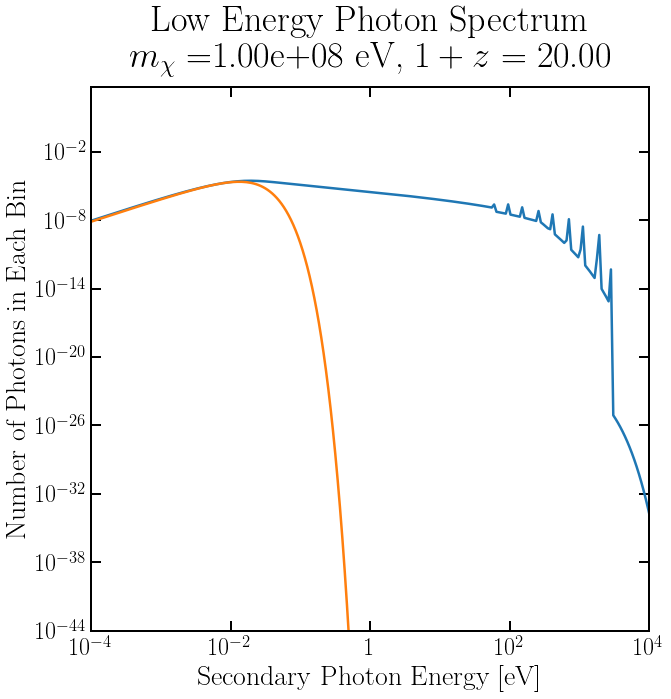

In [152]:
plt.figure()

rs_plot = 20.0

ax = plt.gca()
tf_plot, = a[3].plot(ax, ind=rs_plot, fac=1, indtype='rs')
CMB_plot, = CMB_spectra.plot(ax, ind=rs_plot, indtype='rs')
# tf_plot, = lowengphot_spectra.plot(ax, ind=20)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mDM)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

#ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e4, 1e-44, 5000])

#plt.savefig('/home/gridgway/Desktop/CMB_subtract.png')

In [230]:
temp2 = np.array([
    np.append(rs,compute_fs(
        Spectrum(temp[3].eng, elec_spec, rs=rs, spec_type='N'), 
        Spectrum(temp[3].eng, phot_spec, rs=rs, spec_type='N'),
        np.array([1-xe, 0, 0]), 
        rate_func_decay_eng(rs), 
        highengphot_tf_interp.dlnz/phys.hubble(rs)
    ))
    for (rs, xe, phot_spec, elec_spec) in zip(temp[3].rs[1:], temp[0][1:], temp[3], temp[4])
])
print(temp2[-20:])

AttributeError: 'numpy.ndarray' object has no attribute 'rs'

# NEED TO CHECK

In [393]:
import darkhistory.low_energy.lowE_deposition as lowE_dep
%autoreload

time=-2
tau=1e23
rs_tmp = a1[3][time].rs
print(sum(lowE_dep.compute_fs(
    a1[4][time], 
    a1[3][time], 
    np.array([1-xe_std(rs_tmp),0,0]), 
    rate_func_eng(rs_tmp), 
    .002/phys.hubble(rs_tmp), 
    0
))*rate_func_eng(rs_tmp)*.002/phys.hubble(rs_tmp)/phys.nB/rs_tmp**3)
print(a1[4][time].toteng()+a1[3][time].toteng())

0.0054045385439492315
0.005405394701886692


-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

-Why don't we go above 5 TeV?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation


- Structure Formation
    - swave
    - on/off switch
    - optimistic/conservative
    - (just a change to the annihilation rate)
    
- minimum lifetime (do this first, structure independent)/maximum cross-section
    - residual plot of with back-reaction vs. not back-react (temperature), contour plots
    - for each mass pick the minimum tau or maximum cross-section and compare the std_switch on or off
    
- New 21cm sensitivity
    - Hongwan's plots, but now with DarkHistory